In [2]:
pip install timestring natsort pywaffle

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import json
import timestring
import glob
from natsort import natsorted, ns
from pywaffle import Waffle

In [4]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [5]:
# define functions
# generate random string in case wanted to anonimize data
def generate_random_string(N):
    return "".join(random.SystemRandom().choice(string.ascii_lowercase + string.ascii_uppercase + string.digits)for _ in range(N))

# really specific function to extract data from tasks.json files to grab job count and walltime measures by speciifc groupings (by_key = user, app, project)
def extract_grouping_data(tasks,measure_key,by_key):
    
    # identify by_key list
    tmp_list = []
    for i in list(tasks.keys()):
        tmp_list = tmp_list + [ f[measure_key] for f in tasks[i][by_key] if f[measure_key] is not None and f[measure_key] != 0 ]

    tmp_list = np.unique(tmp_list)

    # set up variables to append through loop
    tmp_jobs = {}
    tmp_walltime = {}
    tmp = []
    dates = []
    counts = []
    walltime = []

    # loop through tmp list and grab stats per by_key over time
    for r in tmp_list:
        tmp_jobs[r] = []
        tmp_walltime[r] = []
        for i in list(tasks.keys()):
            dates = dates + [i]
            tmp = tmp + [r]
            tmp_index = [ f for f in range(len(tasks[i][by_key])) if tasks[i][by_key][f][measure_key] == r ]
            if tmp_index:
                tmp_index = tmp_index[0]
                tmp_jobs[r] = tmp_jobs[r] + [tasks[i][by_key][tmp_index]['jobCount']]
                tmp_walltime[r] = tmp_walltime[r] + [tasks[i][by_key][tmp_index]['jobWalltime']]
            else:
                tmp_jobs[r] = tmp_jobs[r] + [0]
                tmp_walltime[r] = tmp_walltime[r] + [0]

        counts = counts + tmp_jobs[r]
        walltime = walltime + tmp_walltime[r]

    # generate dataframe of important metrics 
    df = pd.DataFrame()
    df[measure_key] = tmp
    df['date'] = dates
    df['jobCount'] = counts
    df['walltime'] = walltime
    df.drop_duplicates(inplace=True)

    return df

# extract count information from user survey data
def extract_user_survey_information(survey,questionID):
    # set up top variables, including a variable to capture the unique responses and the responeses themselves in list form
    unique_responses = []
    responses = survey[questionID].tolist()
    number_respondants = len(responses)
    counts = {}
    
    # loop through responses to identify the unique ones. have to do this because users could respond to multple prompts for some questions
    for i in responses:
        if pd.isna(i):
            tmp = 'not answered'
            if tmp not in unique_responses:
                unique_responses = unique_responses + [tmp]
        else:
            tmp = i.replace(":","").split(',')
            for j in tmp:
                if j not in unique_responses:
                    unique_responses = unique_responses + [j]


    # loop through unique responses and start counting for each unique response
    for i in range(len(unique_responses)):
        if unique_responses[i] != 'not answered':
            counts[unique_responses[i]] = 0
            for j in responses:
                if not pd.isna(j):
                    if unique_responses[i] in j:
                        counts[unique_responses[i]] = counts[unique_responses[i]]+1
        else:
            counts['not answered'] = 0
            for j in responses:
                if pd.isna(j):
                    counts['not answered'] = counts['not answered']+1
    
    # generate dataframe
    out_df = pd.DataFrame()
    out_df['questionID'] = [ questionID for f in range(len(unique_responses)) ]
    out_df['response'] = unique_responses
    out_df['count'] = list(counts.values())
    out_df['percentages'] = (out_df['count'] / number_respondants) * 100
    
    return out_df

def summarize_user_survey_data(survey,question_list,question_description):
    
    out_df = pd.DataFrame()
    
    for i in range(len(question_list)):
        tmp = extract_user_survey_information(survey,question_list[i])
        tmp['question_description'] = [ question_description[i] for f in range(len(tmp['questionID'])) ]
        out_df = pd.concat([out_df,tmp])
    
    return out_df

### User survey results
This section compiles and describes the results from the user survey given out in both 2021 and 2022

In [6]:
### USER SURVEY RESULTS
## user survey results - 2022
# load raw results
user_survey_2022 = pd.read_csv('./user-survey/brainlife_user_survey_5_23_22.csv',header=0,skiprows=[1,2])

# questions of interest
questions_description = ['how_often_visit','type_of_institution','role','how_often_share_code','other_open_science_platforms',
                         'use_brainlife_for','agree_with_brainlifes_mission','good_features_of_open_science',
                         'rating_sense_of_community','rating_reproducibility_of_tools','rating_compute_resources',
                         'rating_responsiveness_of_services','rating_user_interface','rating_quality_of_support_and_tools',
                         'rating_api_access','rating_cli_access']

# question IDs for 2022 survey
questions_list = ['Q4','Q5','Q7','Q8','Q9','Q10','Q11','Q12','Q14','Q15','Q16','Q17','Q18','Q19','Q20','Q21']

# setup counts dataframe for user survey responses
user_survey_2022_counts = summarize_user_survey_data(user_survey_2022,questions_list,questions_description)
user_survey_2022_counts['year'] = [ '2022' for f in range(len(user_survey_2022_counts)) ]

## user survey results - 2022
# load raw results
user_survey_2021 = pd.read_csv('./user-survey/brainlife_user_survey_3_10_21.csv',header=0,skiprows=[1,2])

# question IDs for 2021 survey
questions_list = ['Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10','Q11','Q12','Q13','Q14','Q15','Q16','Q17']

# setup counts dataframe for user survey responses
user_survey_2021_counts = summarize_user_survey_data(user_survey_2021,questions_list,questions_description)
user_survey_2021_counts['year'] = [ '2021' for f in range(len(user_survey_2021_counts)) ]

## concatenate years
user_survey_counts = pd.concat([user_survey_2021_counts,user_survey_2022_counts])
user_survey_counts

,questionID,response,count,percentages,question_description,year
0,Q2,A few times per month,5,12.820513,how_often_visit,2021
1,Q2,Occasionally/as research calls for it,14,35.897436,how_often_visit,2021
2,Q2,A few times per week,7,17.948718,how_often_visit,2021
3,Q2,not answered,6,15.384615,how_often_visit,2021
4,Q2,Almost daily or daily,7,17.948718,how_often_visit,2021
...,...,...,...,...,...,...
0,Q21,Very Good,6,13.636364,rating_cli_access,2022
1,Q21,Good,25,56.818182,rating_cli_access,2022
2,Q21,Fair,12,27.272727,rating_cli_access,2022
3,Q21,Bad,1,2.272727,rating_cli_access,2022


In [78]:
user_survey_counts.question_description.unique().tolist()

['how_often_visit',
 'type_of_institution',
 'role',
 'how_often_share_code',
 'other_open_science_platforms',
 'use_brainlife_for',
 'agree_with_brainlifes_mission',
 'good_features_of_open_science',
 'rating_sense_of_community',
 'rating_reproducibility_of_tools',
 'rating_compute_resources',
 'rating_responsiveness_of_services',
 'rating_user_interface',
 'rating_quality_of_support_and_tools',
 'rating_api_access',
 'rating_cli_access']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


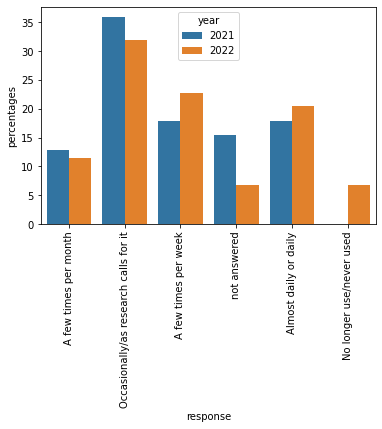

In [81]:
# how often visit
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'how_often_visit'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_how_often_visit.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_how_often_visit.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


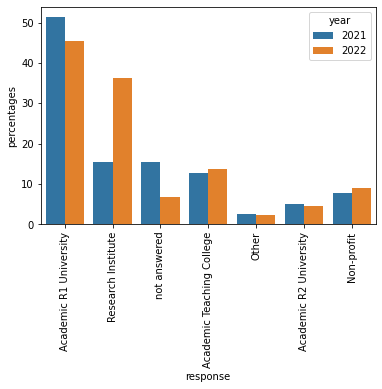

In [82]:
# type of institution
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'type_of_institution'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_type_of_institution.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_type_of_institution.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


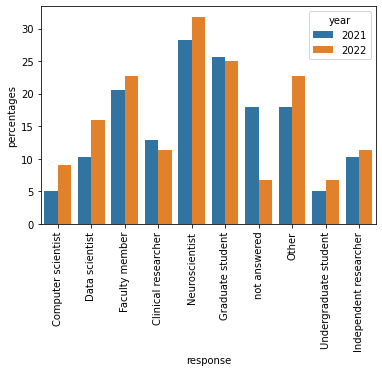

In [83]:
# role
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'role'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_role.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_role.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


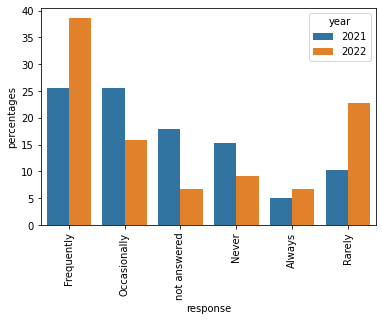

In [84]:
# how often share code
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'how_often_share_code'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_how_often_share_code.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_how_often_share_code.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


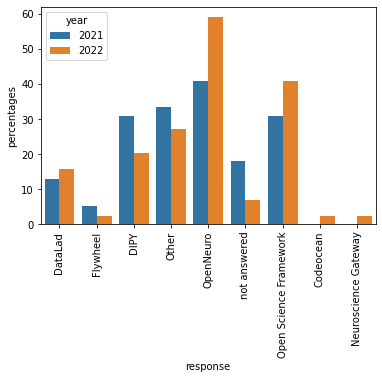

In [85]:
# other open science platforms
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'other_open_science_platforms'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_other_open_science_platforms.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_other_open_science_platforms.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


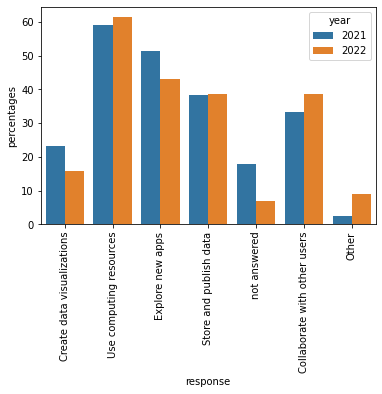

In [86]:
# use brainlife for
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'use_brainlife_for'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_use_brainlife_for.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_use_brainlife_for.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


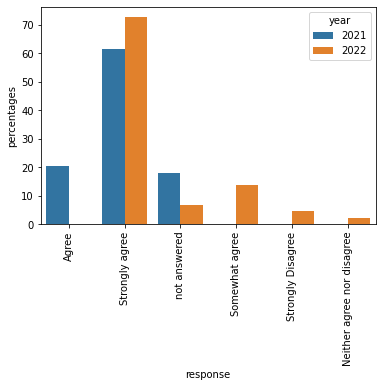

In [87]:
# agree with brainlife's mission statement
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'agree_with_brainlifes_mission'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_agree_with_brainlifes_mission.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_agree_with_brainlifes_mission.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


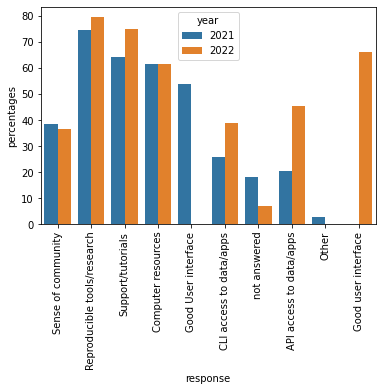

In [88]:
# good features of open science platforms
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'good_features_of_open_science'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_features_of_open_science_platforms.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_features_of_open_science_platforms.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


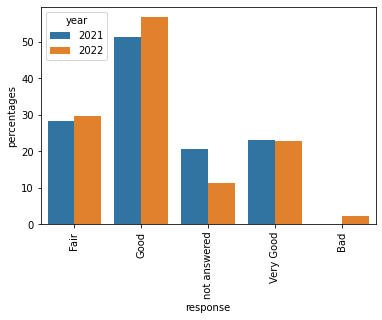

In [89]:
# ratings - sense of community
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_sense_of_community'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-sense_of_community.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-sense_of_community.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


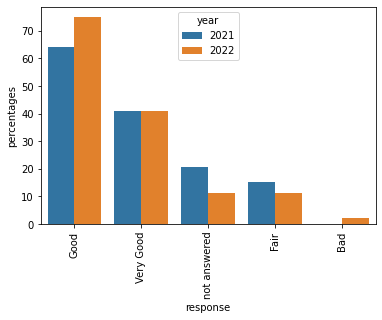

In [90]:
# ratings - reproducibility of tools
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_reproducibility_of_tools'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-reproducibility_of_tools.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-reproducibility_of_tools.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


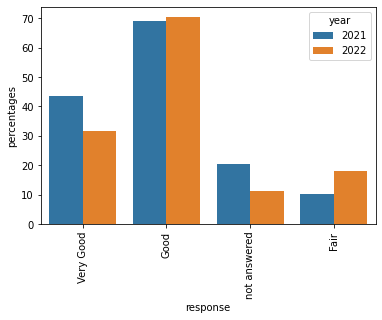

In [91]:
# ratings - computing resources
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_compute_resources'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-compute_resources.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-compute_resources.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


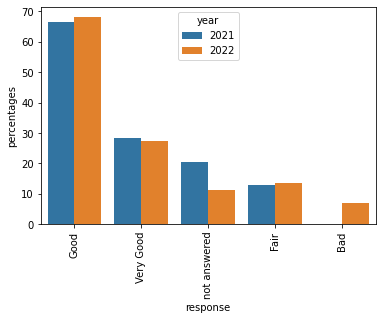

In [92]:
# ratings - responsiveness of services
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_responsiveness_of_services'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-responsiveness_of_services.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-responsiveness_of_services.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


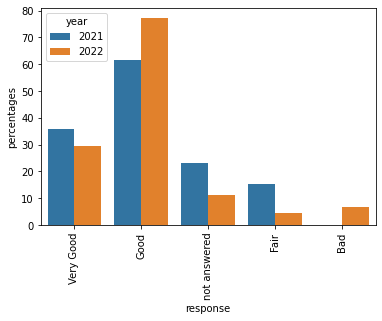

In [93]:
# ratings - user interface
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_user_interface'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-user_interface.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-user_interface.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


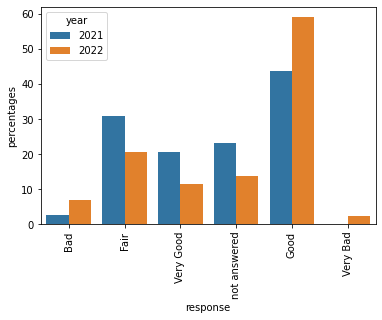

In [94]:
# ratings - quality of services and tools
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_quality_of_support_and_tools'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-quality_of_services.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-quality_of_services.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


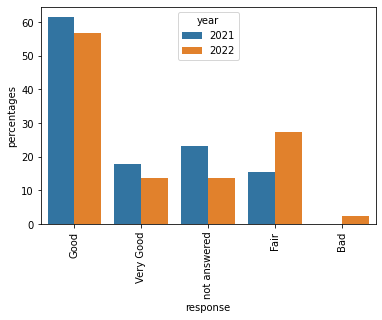

In [95]:
# ratings - api access to data and tools
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_api_access'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-api_access.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-api_access.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


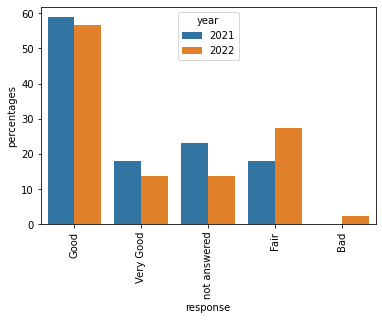

In [96]:
# ratings - cli access to data and tools
sns.barplot(x='response',y='percentages',hue='year',data=user_survey_counts.loc[user_survey_counts['question_description'] == 'rating_cli_access'])
plt.xticks(rotation=90)
plt.savefig('./img/user_survey_ratings-cli_access.png',dpi=300, bbox_inches = "tight")
plt.savefig('./img/user_survey_ratings-cli_access.eps')

## Backend compiling results
This next section describes the results compiled by Soichi Hayashi regarding user statistics directly from the backend of brainlife

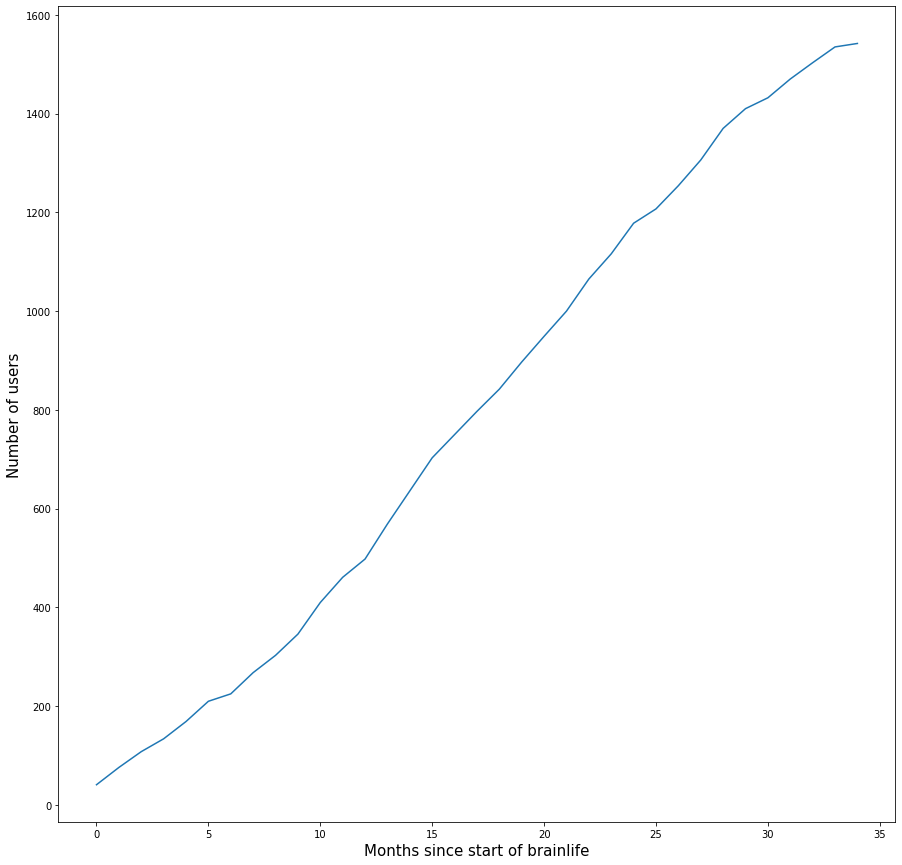

In [4]:
# Total number of user accounts created (an proxy for the attention received by the project)
# load users.confirmTimes data
users_confirm_times = pd.read_csv('./data/users.confirmTime.csv')

# update create_date to be proper datetime
create_date = []
for f in users_confirm_times['confirmTime']:
    if pd.notnull(f):
        if 'GMT' in str(f):
            tmp = f.replace(" (Coordinated Universal Time)","").replace(" GMT+0000","")
            create_date = create_date + [pd.to_datetime(tmp,dayfirst=True,utc=True,format="%a %b %d %Y %H:%M:%S")]
        else:
            create_date = create_date + [pd.to_datetime(f)]
    else:
        create_date = create_date + ['nan']

users_confirm_times['create_date'] = create_date

# groupby 1 month bins
one_month_users_confirm_times = users_confirm_times.loc[users_confirm_times['create_date'] != 'nan'].groupby(pd.Grouper(key='create_date',freq='1M')).count().reset_index().cumsum()
 
# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(one_month_users_confirm_times['create_date'])),y=one_month_users_confirm_times['sub'])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of users',size=15)
plt.savefig('./img/number_of_users_since_start_brainlife.png')
plt.savefig('./img/number_of_users_since_start_brainlife.eps')

In [66]:
users = pd.read_json('./data/user.geocodes.json')
cleaned_users = users.dropna(subset='institution')
users_with_country = users.dropna()
users_with_country['country'] = [ f['country'] for f in users_with_country['geocode'] ]
# users['institution_1'] = [ f.split('/')[0] if '/' in f else f for f in users['institution'] if f != None ]
# users['institution_2'] = [ f.split('/')[1] if '/' in f else f for f in users['institution'] if f != None ]


/tmp/ipykernel_663109/2398758439.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_country['country'] = [ f['country'] for f in users_with_country['geocode'] ]


In [10]:
users

NameError: name 'users' is not defined

/tmp/ipykernel_663109/4156845018.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('users_countries_waffle.eps',format='eps',bbox_inches='tight')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/bacaron/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


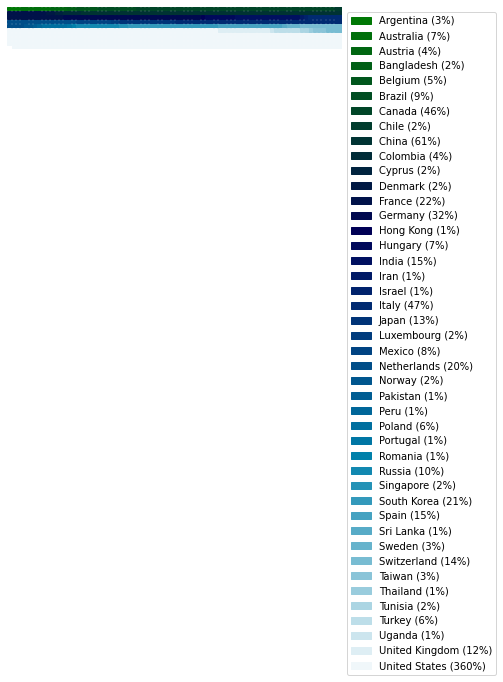

In [99]:
users_country_dict = users_with_country.groupby('country').count()['institution'].to_dict()
# countries = users_with_country.index
# # users_with_country.to_dict('index')
# countries

# fig = plt.figure(
#     FigureClass=Waffle,
#     rows=50,
#     values=users_country_dict
# )
# plt.show()
colormaps = list(sns.color_palette("ocean", len(users_country_dict)))

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=users_country_dict,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in users_country_dict.items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)
# ax = plt.gca()
# ax.get_legend().remove()
plt.savefig('users_countries_waffle.eps',format='eps',bbox_inches='tight')

In [110]:
total = 779
percentages = [ (users_country_dict[f] / total) * 100 for f in users_country_dict ]
# for i in users_country_dict:
#     users_country_dict[i]['percent'] = users_country_dict[i] / total
    
# users_country_dict

In [117]:
tmp = pd.DataFrame()
tmp['country'] = list(users_country_dict.keys())
tmp['percentages'] = np.round(percentages,2)
tmp
# percentages,users_country_dict.keys()

,country,percentages
0,Argentina,0.39
1,Australia,0.90
2,Austria,0.51
3,Bangladesh,0.26
4,Belgium,0.64
5,Brazil,1.16
6,Canada,5.91
7,Chile,0.26
8,China,7.83
9,Colombia,0.51


In [13]:
users = pd.read_csv('./data/users.profile.apps.PRIVATE_DATA.csv')
users.keys().tolist()
# cleaned_users = users.dropna(subset='position')
# cleaned_users
# users_with_country = users.dropna()
# users_with_country['country'] = [ f['country'] for f in users_with_country['geocode'] ]

/tmp/ipykernel_1480705/2702590895.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('./data/users.profile.apps.PRIVATE_DATA.csv')


['position',
 'purpose',
 'institution',
 'lat',
 'lng',
 'totalTasks',
 'appCount.giulia-berto/app-resample-tck',
 'appRuntime.giulia-berto/app-resample-tck',
 'appCount.kathrynalpert/app-hcp-freesurfer',
 'appRuntime.kathrynalpert/app-hcp-freesurfer',
 'appCount.brain-life/app-dtiinit',
 'appRuntime.brain-life/app-dtiinit',
 'appCount.giulia-berto/app-plot-tract-measures',
 'appRuntime.giulia-berto/app-plot-tract-measures',
 'appCount.brainlife/app-snr_in_cc',
 'appRuntime.brainlife/app-snr_in_cc',
 'appCount.brainlife/app-plot-classified-streamlines',
 'appRuntime.brainlife/app-plot-classified-streamlines',
 'appCount.davhunt/app-analyzePRF',
 'appRuntime.davhunt/app-analyzePRF',
 'appCount.brainlife/app-mrtrix3-dwi-brainmask',
 'appRuntime.brainlife/app-mrtrix3-dwi-brainmask',
 'appCount.filipinascimento/bl-network-communities',
 'appRuntime.filipinascimento/bl-network-communities',
 'appCount.brainlife/app-SliceAtlasViaCoords',
 'appRuntime.brainlife/app-SliceAtlasViaCoords',
 'ap

In [44]:
user_input_positions= cleaned_users.position.unique().tolist()
user_input_positions


['Software Engineer',
 'Graduate Student',
 'Reviewer',
 'Associate Professor',
 'Postdoctoral Researcher',
 'Postdoc',
 'Assistant Professor',
 'postdoc',
 'Software Developer',
 'PhD Student',
 'PhD student',
 'Postdoctoral Research Associate',
 'Research Associate',
 'Research Fellow',
 'PhD candidate',
 'Researcher',
 'PhD Candidate',
 'graduate student',
 'Research Assistant Professor',
 'Undergraduate Researcher',
 'Undergraduate student',
 'Student',
 'Prof',
 'Part-time developer',
 'Ph.D. Student - Research Assistant',
 'Senior postdoc',
 'Professor',
 'Research Assistant',
 'Professor Emeritus',
 'Research scientist',
 'Principal Research Scientist',
 'Graduate Research Assistant',
 'Eleanor Cox Riggs Professor',
 'Research Scientist',
 'Full professor',
 'Post-doctoral researcher',
 'Staff scientist',
 'Director of the MATTER Lab',
 'Clinician scientist',
 'Postdoctoral Fellow',
 'MRI ',
 'PhD',
 'project manager',
 'researcher',
 'Associate Principal Investigator',
 'Outrea

In [54]:
positions = ['engineer','graduate student','postdoctoral researcher','professor','researcher/scientist','undergraduate student','doctor','other']

In [116]:
phd_count = cleaned_users.loc[(cleaned_users.position.str.count("grad|Grad|phd|PhD|Ph.D.|ph.d|DPhil|PHD|graduate student|md|MD|master|Master|doctoral") > 0) & (cleaned_users.position.str.count("Undergraduate|undergraduate|post|Post|Before|before") == 0)].position.count()
postdoc_count = cleaned_users.loc[cleaned_users.position.str.count("post|Post|POst") > 0].position.count()
undergrad_count = cleaned_users.loc[(cleaned_users.position.str.count("under|Under") > 0) & (cleaned_users.position.str.count("Founder") == 0)].position.count()
professor_count = cleaned_users.loc[(cleaned_users.position.str.count("prof|Prof|lectu|Lectu|instruc|Instruc") > 0) & (cleaned_users.position.str.count("Founder") == 0)].position.count()
doctor_count = cleaned_users.loc[(cleaned_users.position.str.count("Doctor|doctor") > 0) & (cleaned_users.position.str.count("post|POst|Post|doctoral|Doctoral|student") == 0)].position.count()
engineer_count = cleaned_users.loc[(cleaned_users.position.str.count("Coordin|coordin|engin|Engin|developer|Developer|programmer|Programmer|developer|Developer|software|analyst|Analyst") > 0) & (cleaned_users.position.str.count("Data scientist|data scientist|brain scientist|Neuroscientist|neuroscientist|phd|PhD|Ph.D.|post|POst|Post|doctoral|Doctoral|student|staff|Staff") == 0)].position.count()
researcher_count = cleaned_users.loc[(cleaned_users.position.str.count("scient|scient|Neuroscientist|neuroscientist|brain science|research ass|Research Ass| Research ass") > 0) & (cleaned_users.position.str.count("phd|PhD|Ph.D.|post|POst|Post|doctoral|Doctoral|student|staff|Staff") == 0)].position.count()
other_count = len(cleaned_users) - phd_count - postdoc_count - undergrad_count - professor_count - doctor_count - engineer_count - researcher_count
other_count

671

In [117]:
user_category_dict = {'graduate student': 100*(phd_count/len(cleaned_users['position'])), 'postdoctoral': 100*(postdoc_count/len(cleaned_users['position'])), 'undergraduate student': 100*(undergrad_count/len(cleaned_users['position'])), 'professor': 100*(professor_count/len(cleaned_users['position'])), 'doctor': 100*(doctor_count/len(cleaned_users['position'])),'engineer': 100*(engineer_count/len(cleaned_users['position'])), 'researcher': 100*(researcher_count/len(cleaned_users['position'])),'other': 100*(other_count/len(cleaned_users['position']))}
user_category_dict

{'graduate student': 22.14484679665738,
 'postdoctoral': 8.07799442896936,
 'undergraduate student': 1.8802228412256268,
 'professor': 8.70473537604457,
 'doctor': 0.48746518105849584,
 'engineer': 5.083565459610028,
 'researcher': 6.894150417827298,
 'other': 46.72701949860724}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


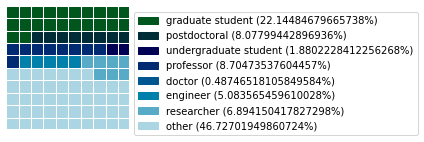

In [118]:
colormaps = list(sns.color_palette("ocean", len(user_category_dict)))

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=user_category_dict,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in user_category_dict.items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)
# ax = plt.gca()
# ax.get_legend().remove()
plt.savefig('users_categories_waffle.eps',format='eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_1396771/1241645065.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('./apps_categories_from_bl_directly_waffle.eps',format='eps',bbox_inches='tight')
/tmp/ipykernel_1396771/1241645065.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig('./apps_categories_from_bl_directly_waffle.png',bbox_inches='tight')
/home/bacaron/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


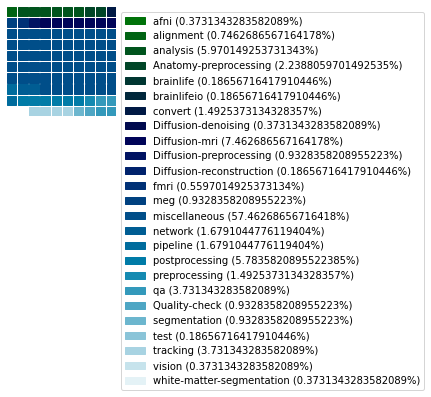

In [38]:
## app categories - raw from brainlife
apps_categories_raw = pd.DataFrame(columns=["category","number_apps"])
apps_categories_raw['category'] = ['afni','alignment','analysis','Anatomy-preprocessing','brainlife','brainlifeio',
                                     'convert','Diffusion-denoising','Diffusion-mri','Diffusion-preprocessing',
                                     'Diffusion-reconstruction','fmri','meg','miscellaneous','network','pipeline',
                                     'postprocessing','preprocessing','qa','Quality-check','segmentation','test',
                                     'tracking','vision','white-matter-segmentation']
apps_categories_raw['number_apps'] = [2,4,32,12,1,1,8,2,40,5,1,3,5,308,9,9,31,8,20,5,5,1,20,2,2]
apps_categories_raw['percent_apps'] = (apps_categories_raw['number_apps'] / sum(apps_categories_raw['number_apps'])) * 100

apps_categories_raw = apps_categories_raw.set_index('category')
apps_categories_raw_dict = apps_categories_raw.to_dict(orient='dict')

colormaps = list(sns.color_palette("ocean", len(apps_categories_raw_dict['percent_apps'])))

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=apps_categories_raw_dict['percent_apps'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in apps_categories_raw_dict['percent_apps'].items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)
# ax = plt.gca()
# ax.get_legend().remove()
plt.savefig('./apps_categories_from_bl_directly_waffle.eps',format='eps',bbox_inches='tight')
plt.savefig('./apps_categories_from_bl_directly_waffle.png',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


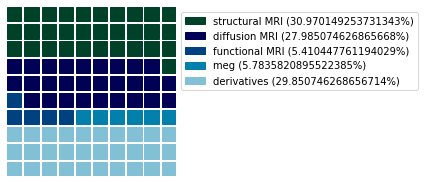

In [39]:
## app categories - datatypes
apps_categories_datatype = pd.DataFrame(columns=["category","number_apps"])
apps_categories_datatype['category'] = ['structural MRI','diffusion MRI','functional MRI','meg','derivatives']
apps_categories_datatype['number_apps'] = [166,150,29,31,160]
apps_categories_datatype['percent_apps'] = (apps_categories_datatype['number_apps'] / sum(apps_categories_datatype['number_apps'])) * 100

apps_categories_datatype = apps_categories_datatype.set_index('category')
apps_categories_datatype_dict = apps_categories_datatype.to_dict(orient='dict')

colormaps = list(sns.color_palette("ocean", len(apps_categories_datatype_dict['percent_apps'])))

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=apps_categories_datatype_dict['percent_apps'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in apps_categories_datatype_dict['percent_apps'].items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)
# ax = plt.gca()
# ax.get_legend().remove()
plt.savefig('apps_categories_datatypes_waffle.eps',format='eps',bbox_inches='tight')
plt.savefig('apps_categories_datatypes_waffle.png',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


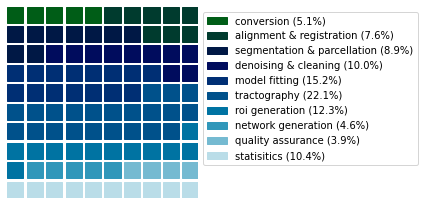

In [213]:
## app categories - processing step
apps_categories_step = pd.DataFrame(columns=["category","number_apps"])
apps_categories_step['category'] = ['conversion','alignment & registration','segmentation & parcellation','denoising & cleaning','model fitting','tractography','roi generation','network generation','quality assurance','statisitics']
apps_categories_step['number_apps'] = [34,51,60,67,102,149,83,31,26,70]
apps_categories_step['percent_apps'] = (apps_categories_step['number_apps'] / sum(apps_categories_step['number_apps'])) * 100

apps_categories_step = apps_categories_step.set_index('category')
apps_categories_step_dict = apps_categories_step.to_dict(orient='dict')

colormaps = list(sns.color_palette("ocean", len(apps_categories_step_dict['percent_apps'])))

round_apps_categories_step_dict = apps_categories_step_dict['percent_apps'].copy()
for key in round_apps_categories_step_dict:
    round_apps_categories_step_dict[key] = np.round(round_apps_categories_step_dict[key],1)

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=round_apps_categories_step_dict,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in round_apps_categories_step_dict.items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)
# ax = plt.gca()
# ax.get_legend().remove()
plt.savefig('apps_categories_steps_waffle.eps',format='eps',bbox_inches='tight')
plt.savefig('apps_categories_steps_waffle.png',bbox_inches='tight')

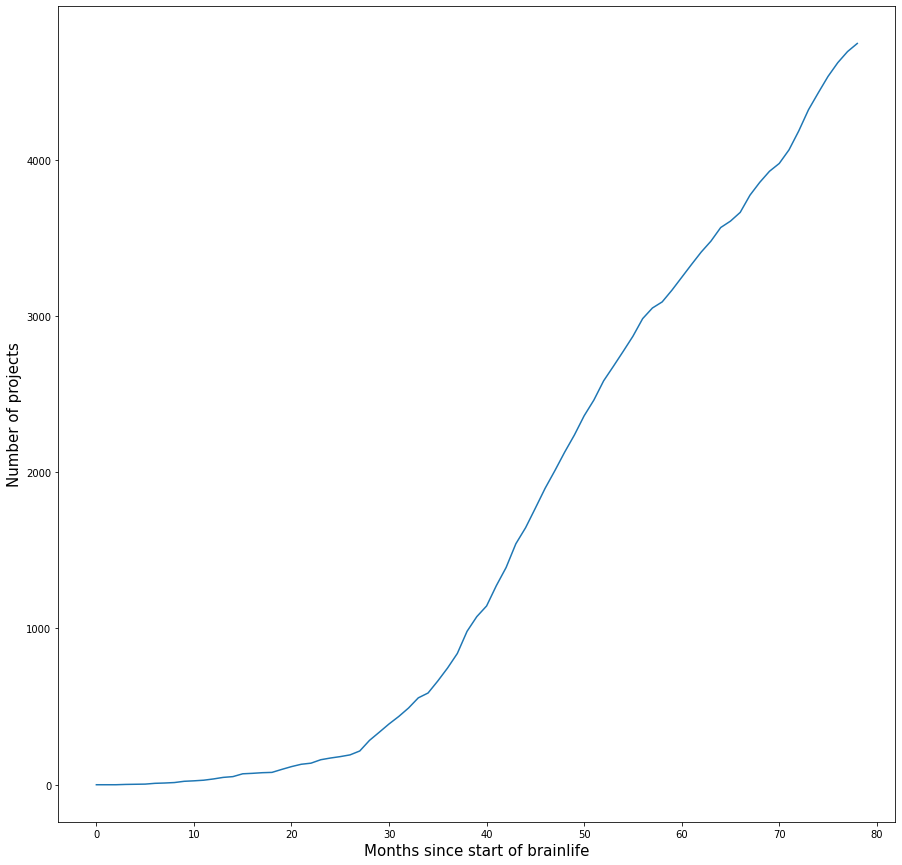

In [85]:
# identify number of projects
# load data
project_stats = pd.read_json('./data/projects.stats.json')

# update create_date to be proper datetime
project_stats['create_date'] = pd.to_datetime(project_stats.create_date)

# groupby 1 month bins
one_month_project_stats = project_stats.groupby(pd.Grouper(key='create_date',freq='1M')).count().reset_index().cumsum()

tmp = pd.DataFrame()
tmp['create_date'] = ['2017-02','2017-03','2017-04']
tmp['name'] = [0,0,0]
tmp['desc'] = [0,0,0]
tmp['stats'] = [0,0,0]
tmp['group_id'] = [0,0,0]
tmp['access'] = [0,0,0]
tmp['admins'] = [0,0,0]
tmp['members'] = [0,0,0]

one_month_project_stats = pd.concat([tmp,one_month_project_stats]).reset_index(drop=True)
one_month_project_stats

# # generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(one_month_project_stats['create_date'])),y=one_month_project_stats['name'])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of projects',size=15)
plt.savefig('./img/number_of_projects_since_start_brainlife.png')
plt.savefig('./img/number_of_projects_since_start_brainlife.eps')

,create_date,name,desc,stats,group_id,access,admins,members
0,2017-02,0,0,0,0,0,0,0
1,2017-03,0,0,0,0,0,0,0
2,2017-04,0,0,0,0,0,0,0
3,2017-05-31 00:00:00+00:00,2,2,2,2,2,2,2
4,2064-11-27 00:00:00+00:00,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...
74,2089-05-21 02:32:37.742690304+00:00,4428,4429,4431,4431,4431,4431,4431
75,2142-10-19 02:32:37.742690304+00:00,4533,4534,4536,4536,4536,4536,4536
76,2196-04-16 02:32:37.742690304+00:00,4621,4622,4624,4624,4624,4624,4624
77,2249-11-14 02:32:37.742690304+00:00,4692,4693,4695,4695,4695,4695,4695


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


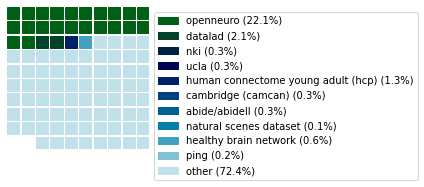

In [204]:
## unique datasets across projects breakdown

total_projects = len(project_stats)
total_openneuro_datalad = 643 # number of datasets available from openneuro and datalad directly


imported_openneuro = project_stats.loc[(project_stats['desc'].str.count("Imported from OpenNeuro|openneuro|datasets.datalad.org/openneuro") > 0) ]
imported_openneuro_count = len(imported_openneuro)
imported_datalad = project_stats.loc[(project_stats['desc'].str.count("Imported from datasets.datalad") > 0) & (project_stats['desc'].str.count("Imported from OpenNeuro|openneuro|datasets.datalad.org/openneuro") == 0)]
imported_datalad_count = len(imported_datalad)

dataset_dictionary = {'openneuro': (imported_openneuro_count / total_projects) * 100,
                                      'datalad': (imported_datalad_count / total_projects) * 100
                                     }

# the above datasets are the number of projects using the data, with duplicate descriptions and names dropped
# .drop_duplicates(['name','desc'])

non_openneuro = project_stats.loc[project_stats['desc'].str.count("OpenNeuro|datasets.datalad.org/openneuro|Imported from datasets.datalad") == 0]
large_datasets = ['NKI','UCLA','HCP','CAMCAN','ABIDE','nsd','healthy-brain-network','ping']

nki_count = non_openneuro.loc[(non_openneuro.name.str.count("NKI|nki") > 0)].name.count()
ucla_count = non_openneuro.loc[(non_openneuro.name.str.count("UCLA|ucla") > 0)].name.count()
hcp_count = non_openneuro.loc[(non_openneuro.name.str.count("HCP|hcp|Human Connectome|human connectome") > 0)].name.count()
camcan_count = non_openneuro.loc[(non_openneuro.name.str.count("CAMCAN|camcan|Cam-CAN|Cambridge|CAM-CAN|CamCan|Run1 vs Run2") > 0)].name.count()
abide_count = non_openneuro.loc[(non_openneuro.name.str.count("abide|ABIDE") > 0)].name.count()
nsd_count = non_openneuro.loc[(non_openneuro.name.str.count("nsd|NSD|Natural Scenes") > 0)].name.count()
hbn_count = non_openneuro.loc[(non_openneuro.name.str.count("hbn|HBN") > 0)].name.count()
ping_count = non_openneuro.loc[(non_openneuro.name.str.count("ping|PING|Pediatric Imaging") > 0)].name.count()

large_dataset_dictionary = {'nki': (nki_count / total_projects) * 100,
                            'ucla': (ucla_count / total_projects) * 100,
                            'human connectome young adult (hcp)': (hcp_count / total_projects) * 100,
                            'cambridge (camcan)': (camcan_count / total_projects) * 100,
                            'abide/abideII': (abide_count / total_projects) * 100,
                            'natural scenes dataset': (nsd_count / total_projects) * 100,
                            'healthy brain network': (hbn_count / total_projects) * 100,
                            'ping': (ping_count / total_projects) * 100
                           }

dataset_dictionary.update(large_dataset_dictionary)

dataset_dictionary['other'] = ((total_projects - np.sum([ ((dataset_dictionary[f])/100)*total_projects for f in dataset_dictionary ])) / total_projects) * 100


round_dataset_dictionary = dataset_dictionary.copy()
for key in round_dataset_dictionary:
    round_dataset_dictionary[key] = np.round(round_dataset_dictionary[key],1)
# round_dataset_dictionary = [ np.round(round_dataset_dictionary[f],1) for f in round_dataset_dictionary ]

colormaps = list(sns.color_palette("ocean", len(round_dataset_dictionary)))

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=round_dataset_dictionary,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in round_dataset_dictionary.items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)
# ax = plt.gca()
# ax.get_legend().remove()
plt.savefig('datasets_waffle.eps',format='eps',bbox_inches='tight')
plt.savefig('datasets_waffle.png',bbox_inches='tight')

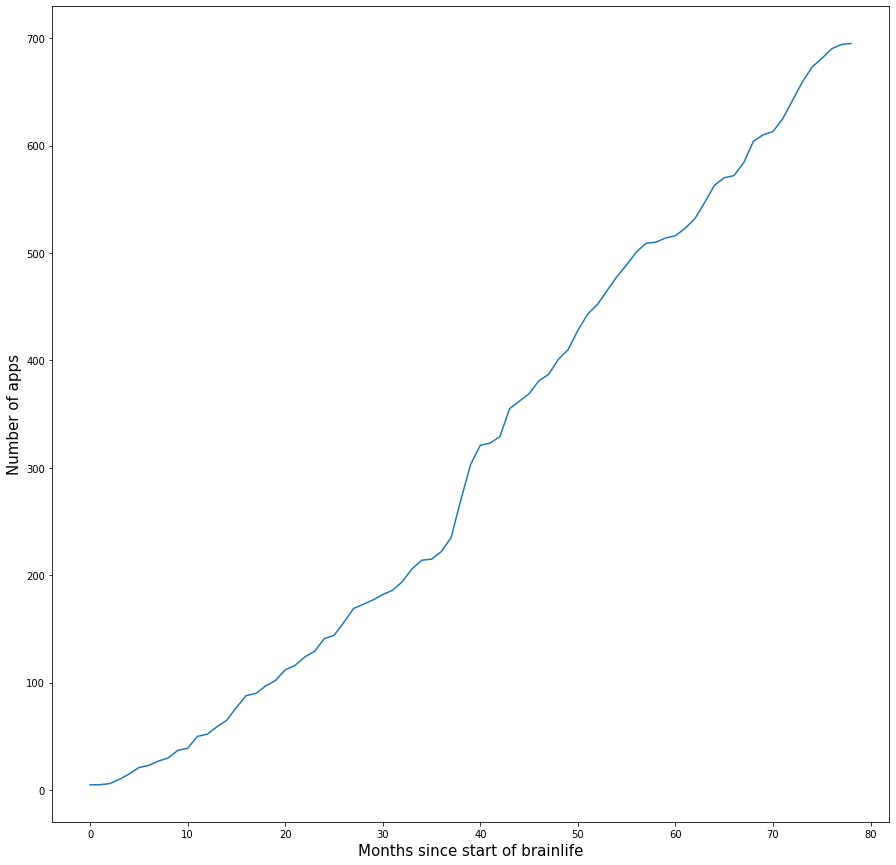

In [71]:
# identify number of apps
# load data
app_stats = pd.read_json('./data/apps.stats.json')

# update create_date to be proper datetime
app_stats['create_date'] = pd.to_datetime(app_stats.create_date)
app_stats

# groupby 1 month bins
one_month_app_stats = app_stats.groupby(pd.Grouper(key='create_date',freq='1M')).count().reset_index().cumsum()

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(one_month_app_stats['create_date'])),y=one_month_app_stats['name'])
ax = plt.gca()
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of apps',size=15)
plt.savefig('./img/number_of_apps_since_start_brainlife.png')
plt.savefig('./img/number_of_apps_since_start_brainlife.eps')

In [70]:
one_month_app_stats

,create_date,name,github,desc,stats,doi
0,2017-02-28 00:00:00+00:00,5,5,5,5,5
1,2064-05-28 00:00:00+00:00,5,5,5,5,5
2,2111-09-26 00:00:00+00:00,6,6,6,6,6
3,2159-02-23 00:00:00+00:00,10,10,10,10,10
4,2206-08-23 00:00:00+00:00,15,15,15,15,15
...,...,...,...,...,...,...
74,2231-02-14 02:32:37.742690304+00:00,673,673,416,673,673
75,1699-12-23 02:58:04.033138688+00:00,681,681,420,681,681
76,1753-06-21 02:58:04.033138688+00:00,690,690,422,690,690
77,1807-01-19 02:58:04.033138688+00:00,694,694,425,694,694


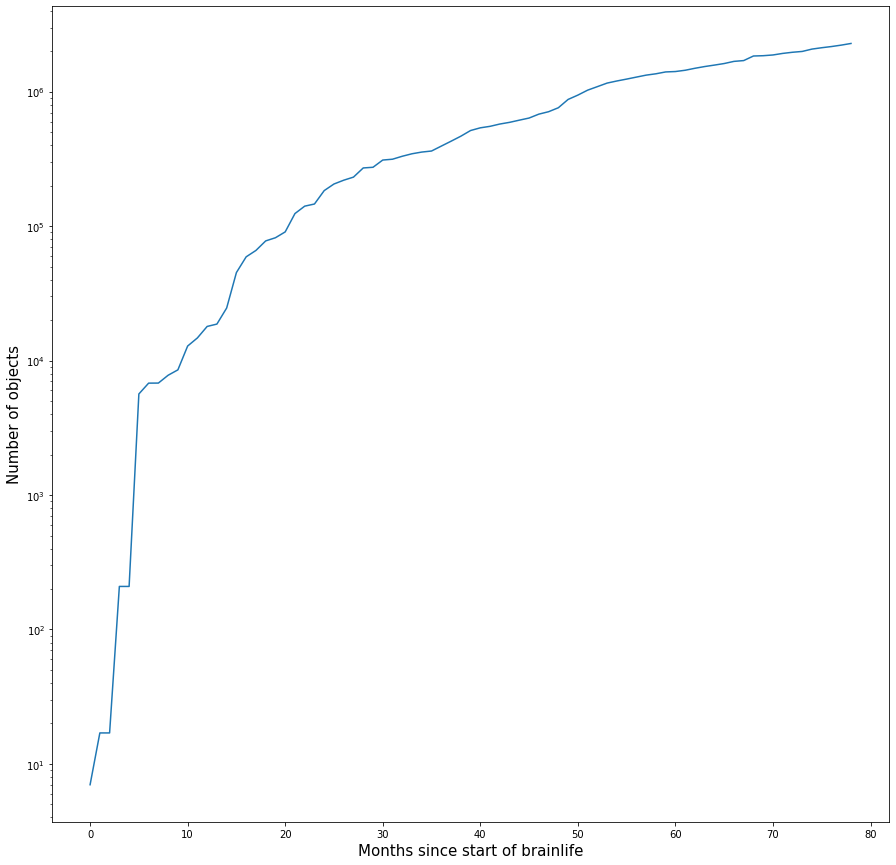

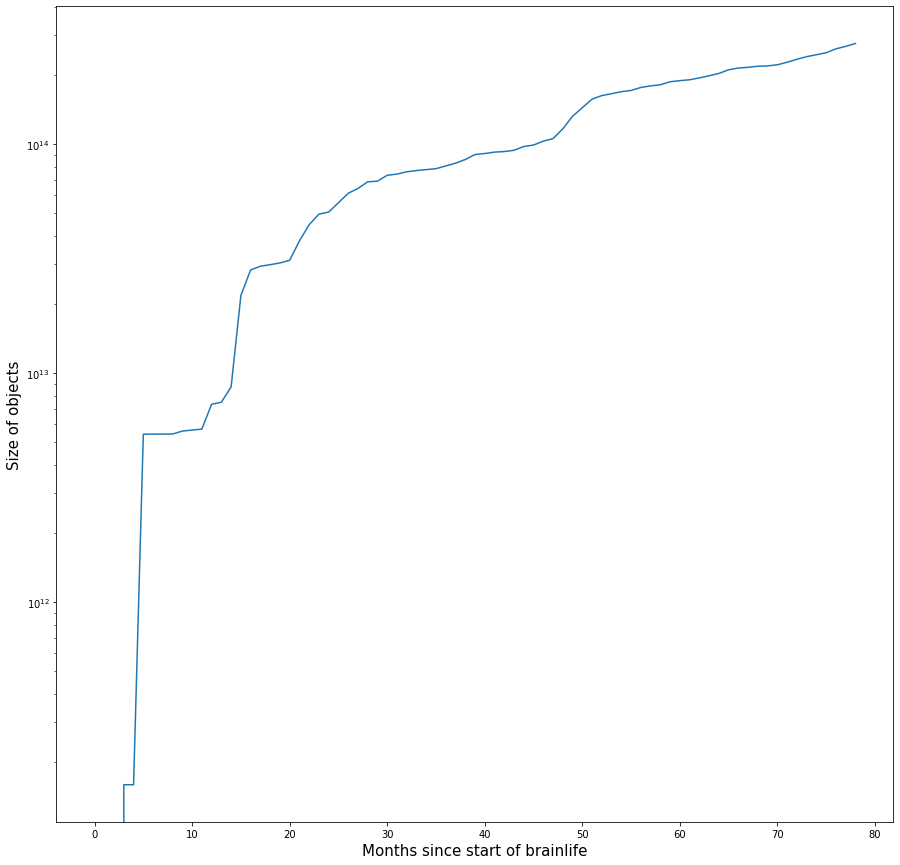

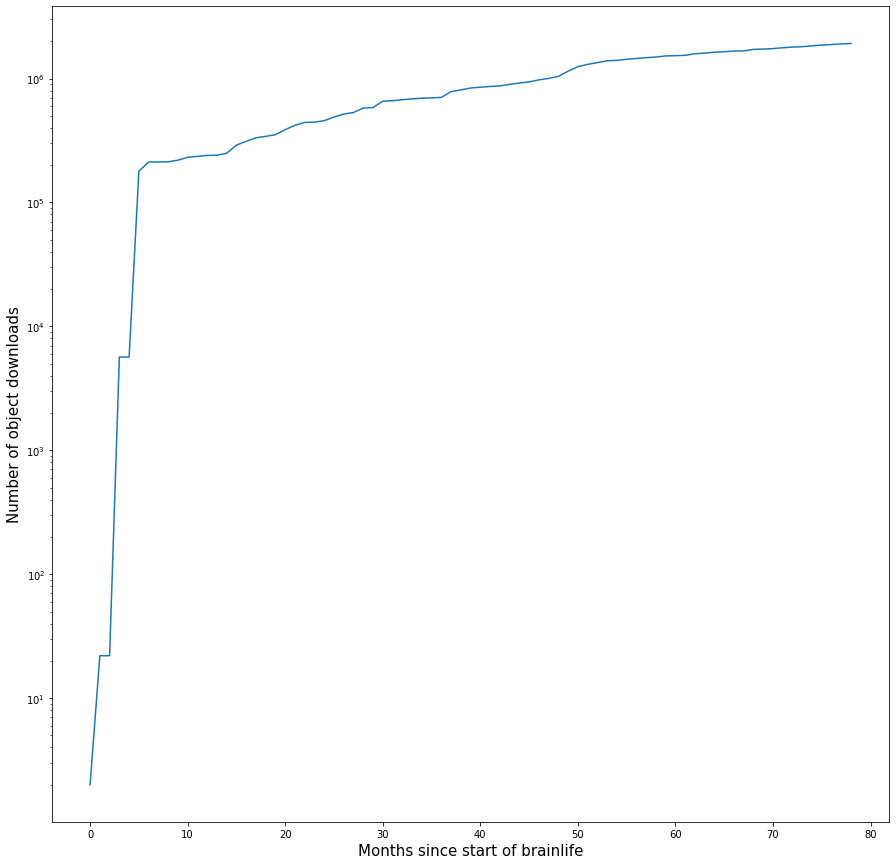

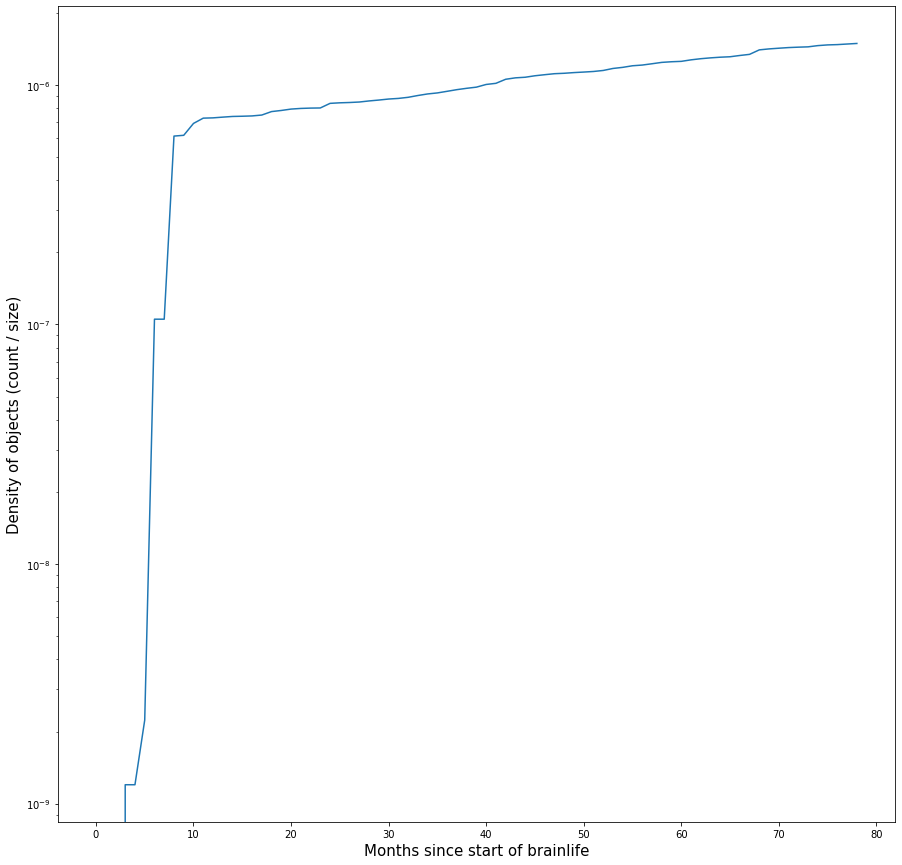

In [53]:
# number of objects and size of objects
# number of objects
# load data

object_files = sorted(glob.glob('./data/objects/*.json'))

# natural sort because the files don't have leading zeros :||||||||
years = ['2017','2018','2019','2020','2021','2022','2023']

sorted_object_files = []

for i in years:
    tmp = [ f for f in object_files if i in f.split('objects.')[1].split('.')[1] ]
    sorted_object_files = sorted_object_files + natsorted(tmp, key=lambda y: y.lower())

# compile objects together
objects = {}

for i in range(len(sorted_object_files)):
    with open(sorted_object_files[i],'r') as file_f:
        obj_data = json.load(file_f)
    
    objects[sorted_object_files[i].split('objects.')[1].split('.json')[0]] = obj_data

dates = list(objects.keys())

objects_dataframe = pd.DataFrame()
objects_dataframe['date'] = [ f for f in range(len(objects)) ]
objects_dataframe['count'] = [ objects[f]['totalObjectCount'] for f in objects ]
objects_dataframe['size'] = [ objects[f]['totalObjectSize'] for f in objects ]
objects_dataframe['downloads'] = [ objects[f]['totalObjectDownload'] for f in objects ]
objects_dataframe['object_density'] = [ objects[f]['totalObjectCount'] / objects[f]['totalObjectSize'] if objects[f]['totalObjectSize'] != 0 else 0 for f in objects ]

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['count'][0:-4])),y=objects_dataframe['count'].cumsum()[0:-4])
p.set(yscale='log')
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of objects',size=15)
plt.savefig('./img/number_of_objects_since_start_brainlife.png')
plt.savefig('./img/number_of_objects_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['size'][0:-4])),y=objects_dataframe['size'].cumsum()[0:-4])
p.set(yscale='log')
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Size of objects',size=15)
plt.savefig('./img/size_of_objects_since_start_brainlife.png')
plt.savefig('./img/size_of_objects_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['downloads'][0:-4])),y=objects_dataframe['downloads'].cumsum()[0:-4])
p.set(yscale='log')
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of object downloads',size=15)
plt.savefig('./img/number_of_object_downloads_since_start_brainlife.png')
plt.savefig('./img/number_of_object_downloads_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(objects_dataframe['object_density'][0:-4])),y=objects_dataframe['object_density'].cumsum()[0:-4])
p.set(yscale='log')
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Density of objects (count / size)',size=15)
plt.savefig('./img/density_of_objects_since_start_brainlife.png')
plt.savefig('./img/density_of_objects_since_start_brainlife.eps')

In [65]:
objects_dataframe[:-4]

,date,count,size,downloads,object_density
0,0,7,0,2,0.000000e+00
1,1,10,0,20,0.000000e+00
2,2,0,0,0,0.000000e+00
3,3,192,159889550848,5629,1.200829e-09
4,4,0,0,0,0.000000e+00
...,...,...,...,...,...
74,74,81951,4800152616960,28309,1.707258e-08
75,75,49005,4939690174464,27551,9.920663e-09
76,76,43635,10120949582848,18152,4.311354e-09
77,77,53204,6453313105920,21059,8.244447e-09


In [52]:
objects_dataframe

,date,count,size,downloads,object_density
0,0,7,0,2,0.000000e+00
1,1,10,0,20,0.000000e+00
2,2,0,0,0,0.000000e+00
3,3,192,159889550848,5629,1.200829e-09
4,4,0,0,0,0.000000e+00
...,...,...,...,...,...
78,78,64117,7996756101120,16572,8.017876e-09
79,79,8783,1615716055040,2102,5.435980e-09
80,80,0,0,0,0.000000e+00
81,81,0,0,0,0.000000e+00


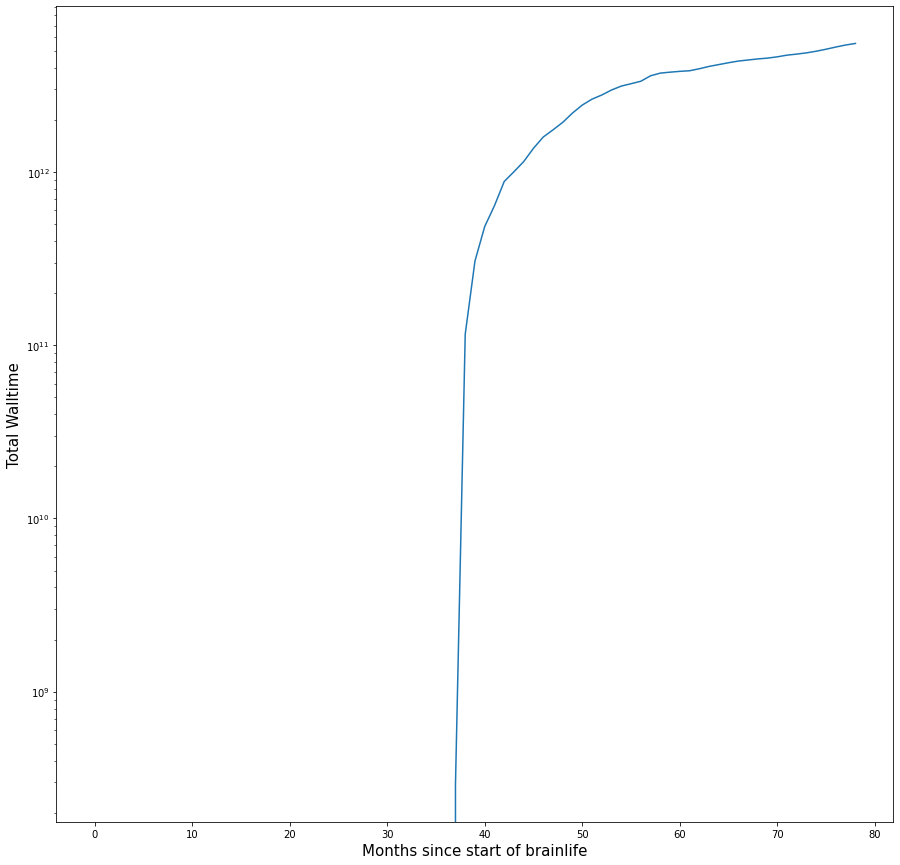

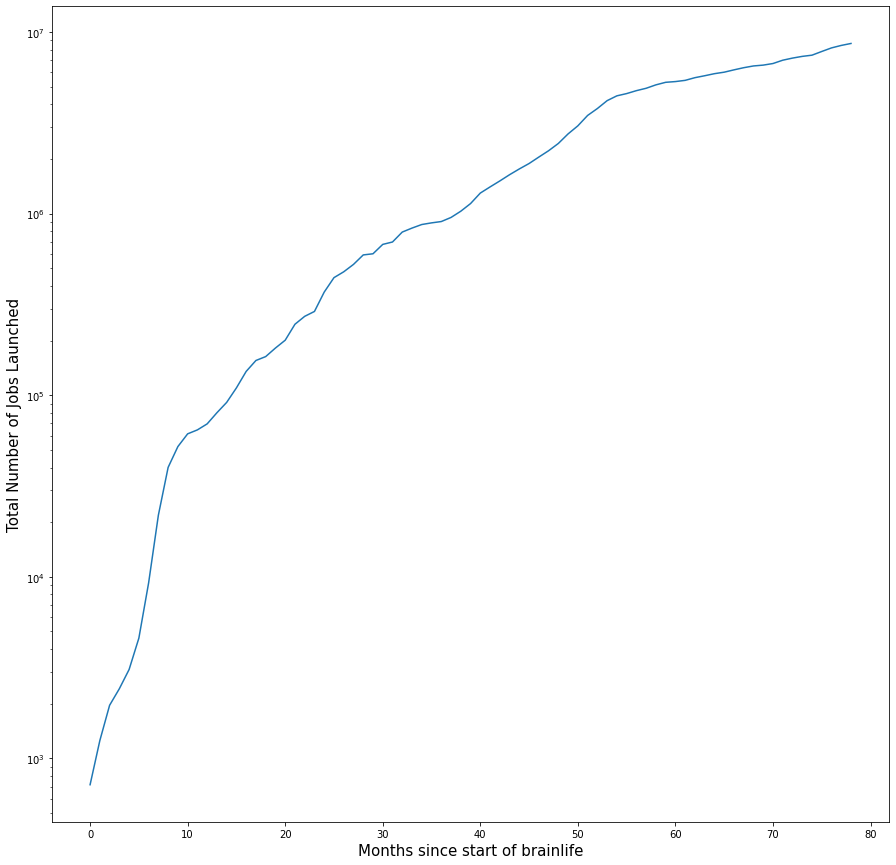

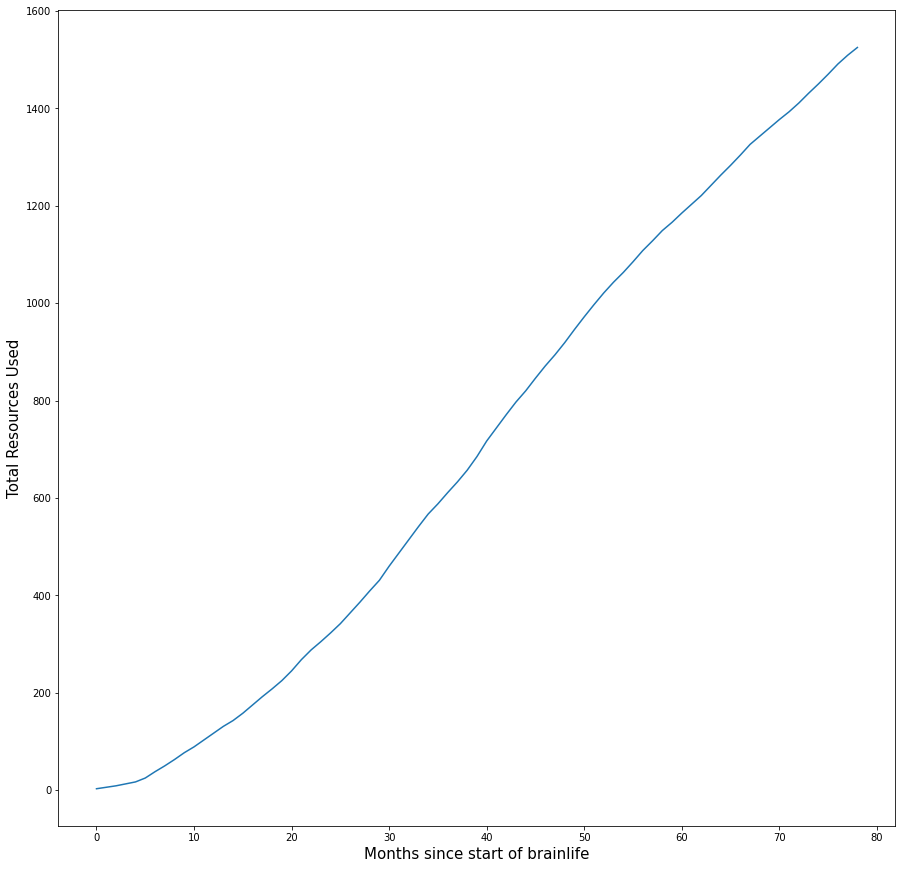

In [6]:
# number of objects and size of objects
# number of objects
# load data

task_files = sorted(glob.glob('./data/tasks/*.json'))

# natural sort because the files don't have leading zeros :||||||||
years = ['2017','2018','2019','2020','2021','2022','2023']

sorted_tasks_files = []

for i in years:
    tmp = [ f for f in task_files if i in f.split('tasks.')[1].split('.')[1] ]
    sorted_tasks_files = sorted_tasks_files + natsorted(tmp, key=lambda y: y.lower())
    
tasks = {}

for i in range(len(sorted_tasks_files)):
    with open(sorted_tasks_files[i],'r') as file_f:
        task_data = json.load(file_f)
    
    tasks[sorted_tasks_files[i].split('tasks.')[1].split('.json')[0]] = task_data

tasks_dataframe = pd.DataFrame()
tasks_dataframe['date'] = [ f for f in range(len(tasks)) ]
tasks_dataframe['walltime'] = [ tasks[f]['totalWalltime'] for f in tasks ]
tasks_dataframe['count'] = [ tasks[f]['totalJobCount'] for f in tasks ]
tasks_dataframe['resources_used'] = [ tasks[f]['totalResources'] for f in tasks ]

# # generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(tasks_dataframe['walltime'][0:-4])),y=tasks_dataframe['walltime'].cumsum()[0:-4])
p.set(yscale='log')
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Walltime',size=15)
plt.savefig('./img/total_walltime_since_start_brainlife.png')
plt.savefig('./img/total_walltime_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(tasks_dataframe['count'][0:-4])),y=tasks_dataframe['count'].cumsum()[0:-4])
p.set(yscale='log')
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Number of Jobs Launched',size=15)
plt.savefig('./img/total_number_jobs_since_start_brainlife.png')
plt.savefig('./img/total_number_jobs_since_start_brainlife.eps')

# generate plot
fig = plt.figure(figsize=(15,15))
p = sns.lineplot(x=np.arange(0,len(tasks_dataframe['resources_used'][0:-4])),y=tasks_dataframe['resources_used'].cumsum()[0:-4])
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Resources Used',size=15)
plt.savefig('./img/total_resources_since_start_brainlife.png')
plt.savefig('./img/total_resources_since_start_brainlife.eps')

In [8]:
tasks_dataframe

,date,walltime,count,resources_used
0,0,0,716,3
1,1,0,538,3
2,2,0,707,3
3,3,0,459,4
4,4,0,668,4
...,...,...,...,...
78,78,112276290415,213162,16
79,79,31314276432,51833,15
80,80,0,0,0
81,81,0,0,0


83

In [34]:
# per resource breakdown
# extract job counts and walltime for resource grouping
tasks_resources = extract_grouping_data(tasks,'resourceName','byResources')

## figures
viridis = cm.get_cmap('viridis',len(tasks_resources.resource.unique()))

# create plot for number of jobs per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_resources.loc[tasks_resources['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_resource_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_resource_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_resources.loc[tasks_resources['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total walltime',size=15)
plt.savefig('./img/total_walltime_by_resource_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_resource_since_start_brainlife.eps')

AttributeError: 'DataFrame' object has no attribute 'resource'

In [33]:
tasks_resources

NameError: name 'tasks_resources' is not defined

In [7]:
# per resource breakdown - top 10
# extract job counts and walltime for resource grouping
resources_top_10 = tasks_resources.groupby('resourceName',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:11]['resourceName'].to_list()
tasks_resources_top_10 = tasks_resources.loc[tasks_resources['resourceName'].isin(resources_top_10)]

## figures
viridis = cm.get_cmap('viridis',len(tasks_resources_top_10.resourceName.unique()))

# # create plot for number of jobs per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources_top_10.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_resources_top_10.loc[tasks_resources_top_10['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_resource_top_10_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_resource_top_10_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_resources_top_10.resourceName.unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_resources_top_10.loc[tasks_resources_top_10['resourceName'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total walltime',size=15)
plt.savefig('./img/total_walltime_by_resource_top_10_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_resource_top_10_since_start_brainlife.eps')

NameError: name 'tasks_resources' is not defined

In [21]:
# per user breakdown
# extract job counts and walltime for users grouping
tasks_users = extract_grouping_data(tasks,'sub','byUsers')
tasks_users['sub'] = [ str(f) for f in tasks_users['sub'] ]

# figures
# set colormap again with length of number of users
# viridis = cm.get_cmap('viridis',len(tasks_users['sub'].unique()))

# create plot for number of jobs per user over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_users['sub'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_users.loc[tasks_users['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Number of Jobs Launched',size=15)
# plt.savefig('./img/number_of_jobs_by_user_since_start_brainlife.png')
# plt.savefig('./img/number_of_jobs_by_user_since_start_brainlife.eps')

# # # create plot for walltime per resource over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_users['sub'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_users.loc[tasks_users['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Walltime',size=15)
# plt.savefig('./img/total_walltime_by_user_since_start_brainlife.png')
# plt.savefig('./img/total_walltime_by_user_since_start_brainlife.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


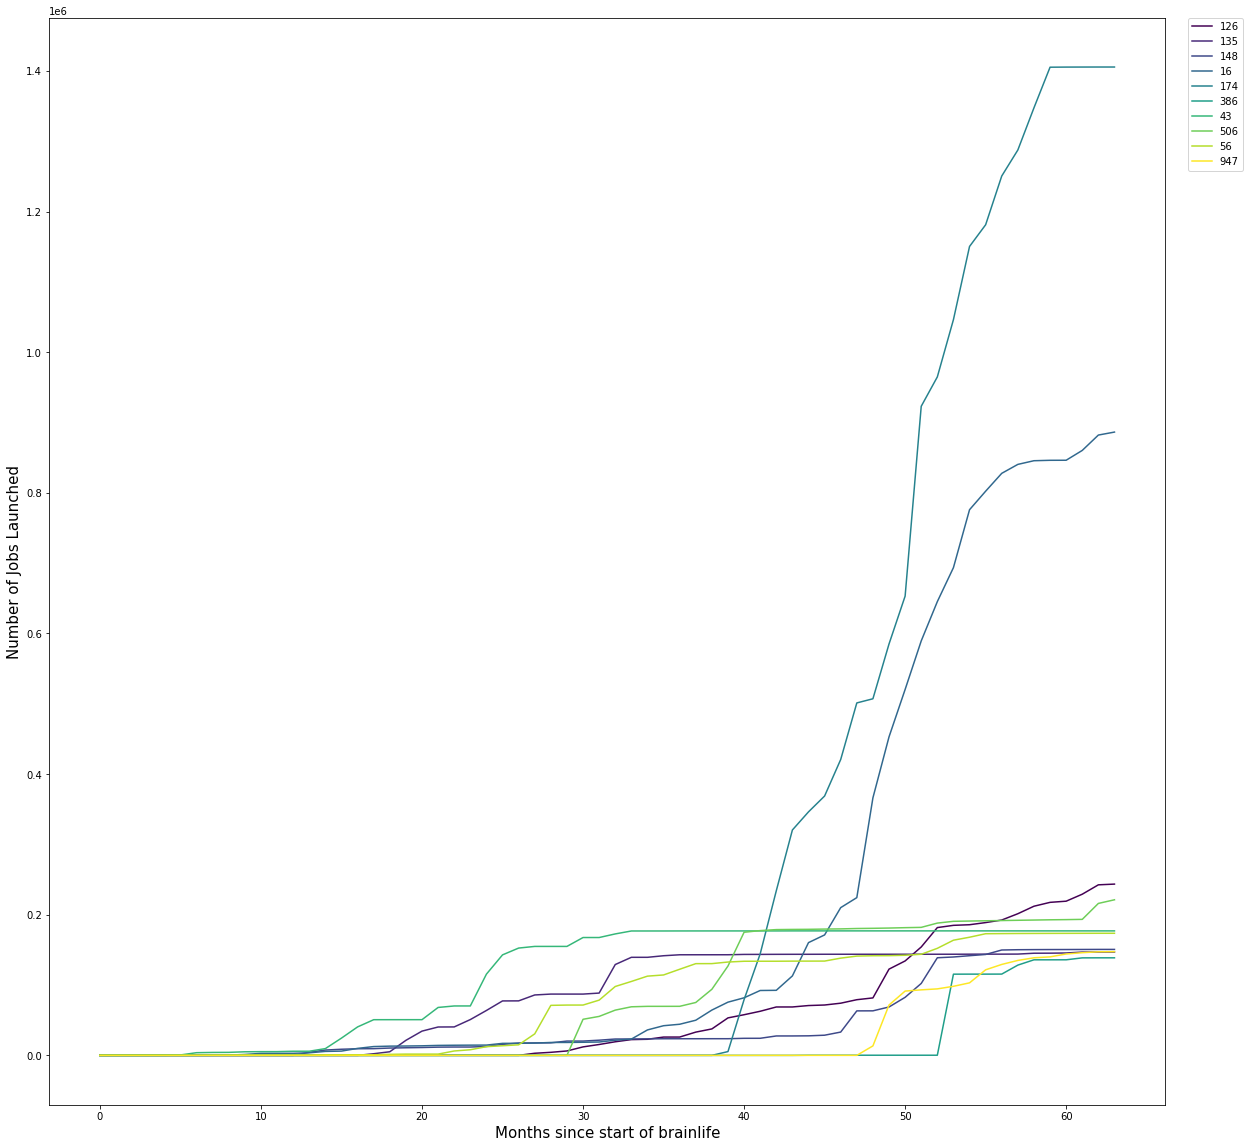

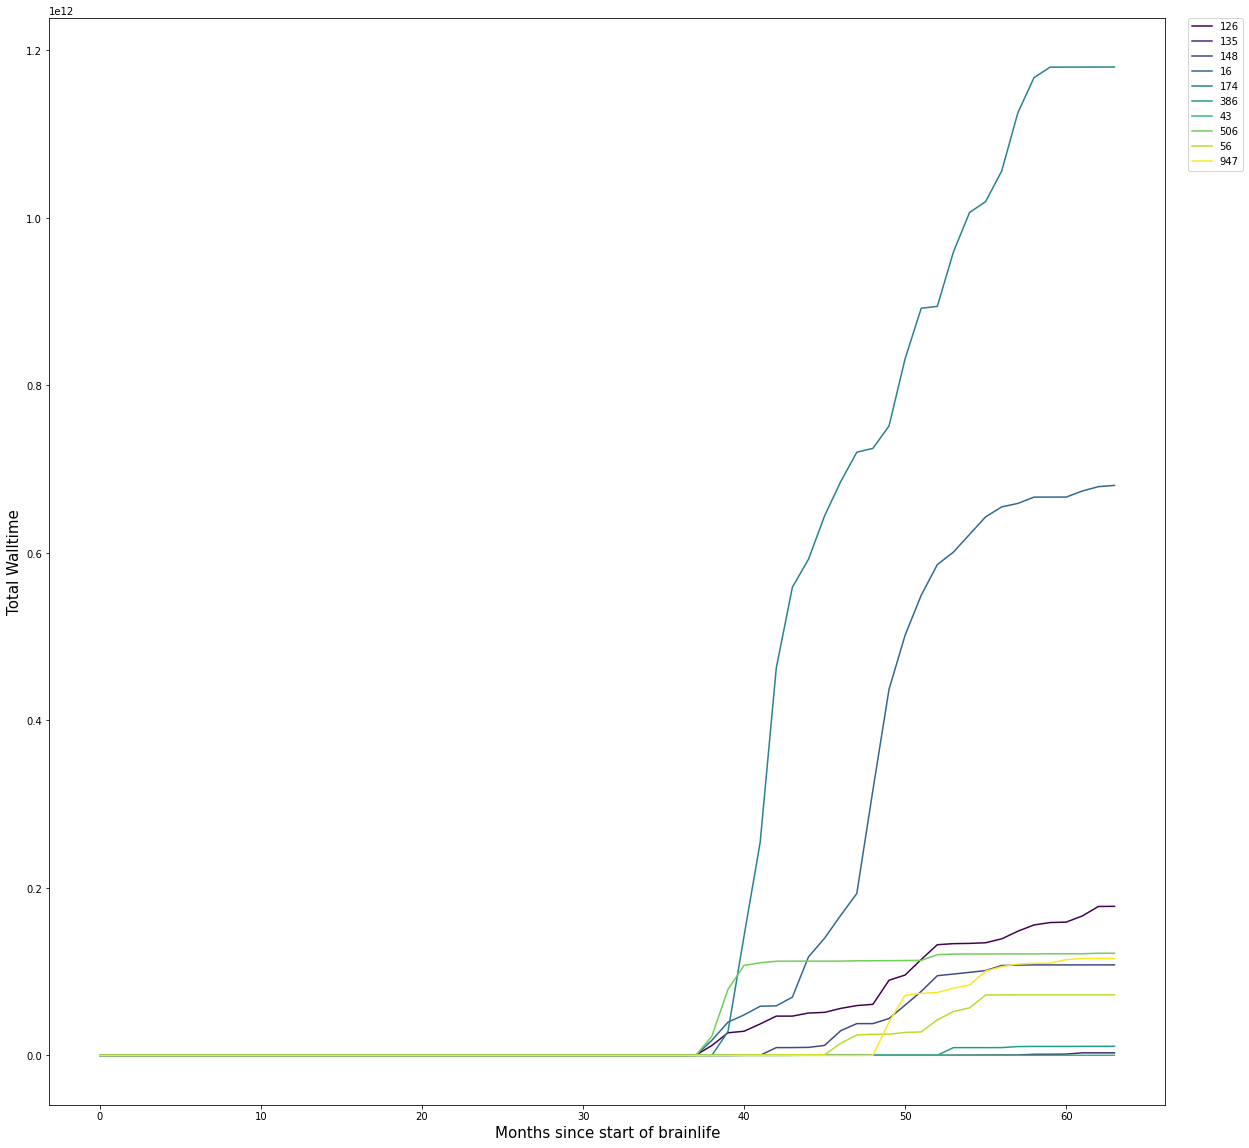

In [10]:
# per user breakdown - top 10
# extract job counts and walltime for users grouping
# tasks_users = extract_grouping_data(tasks,'sub','byUsers')
# tasks_users['sub'] = [ str(f) for f in tasks_users['sub'] ]
users_top_10 = tasks_users.groupby('sub',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:10]['sub'].to_list()
tasks_users_top_10 = tasks_users.loc[tasks_users['sub'].isin(users_top_10)]

# figures
# set colormap again with length of number of users
viridis = cm.get_cmap('viridis',len(tasks_users_top_10['sub'].unique()))

# create plot for number of jobs per user over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_users_top_10['sub'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_users_top_10.loc[tasks_users_top_10['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_user_top_10_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_user_top_10_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_users_top_10['sub'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_users_top_10.loc[tasks_users_top_10['sub'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Walltime',size=15)
plt.savefig('./img/total_walltime_by_user_top_10_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_user_top_10_since_start_brainlife.eps')

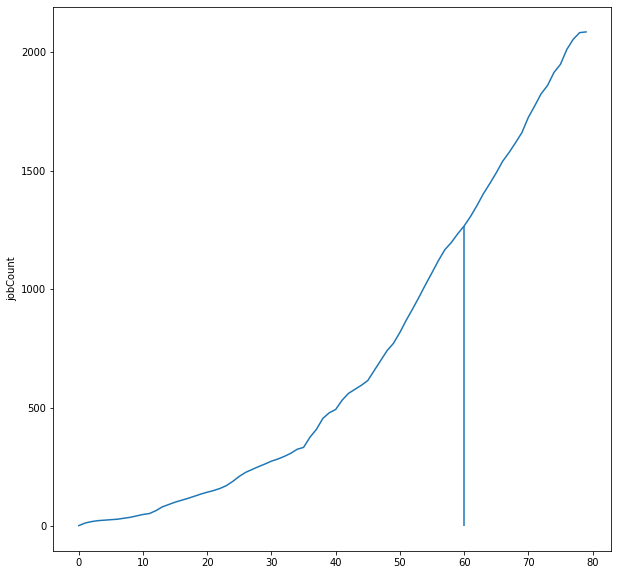

In [22]:
# find active users (more than 10 jobs launched per month)
active_subs = []
active_dates = []
active_counts = []
active_walltime = []

# for i in tasks_users['sub'].unique():
for d in tasks_users['date'].unique():
    tmp = tasks_users.loc[tasks_users['date'] == d]
    tmp_subs = tmp.loc[tmp['jobCount'] > 100]['sub'].tolist()
    tmp_counts = tmp.loc[tmp['jobCount'] > 100]['jobCount'].tolist()
    tmp_walltime = tmp.loc[tmp['jobCount'] > 100]['walltime'].tolist()


    active_subs = active_subs + tmp_subs
    active_dates = active_dates + [ d for f in tmp_subs ]
    active_counts = active_counts + tmp_counts
    active_walltime = active_walltime + tmp_walltime

active_tasks_users = pd.DataFrame()
active_tasks_users['sub'] = active_subs
active_tasks_users['date'] = active_dates
active_tasks_users['jobCount'] = active_counts
active_tasks_users['walltime'] = active_walltime
active_tasks_users = active_tasks_users.sort_values(by=['sub','date'])
active_tasks_users = active_tasks_users.loc[active_tasks_users['sub'] != 'warehouse']

# # create plot for active users over time (more than >100 jobs in a month)
fig = plt.figure(figsize=(10,10))
sns.lineplot(x=np.arange(len(active_tasks_users.groupby('date',sort=False).count().cumsum())),y=active_tasks_users.groupby('date',sort=False).count().cumsum()['jobCount'])
ax = plt.gca()
ax.vlines(x=60,ymin=0,ymax=1266)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total active users (> 100 jobs in a month)',size=15)
# plt.savefig('./img/number_active_users_since_start_brainlife.png')
# plt.savefig('./img/number_active_users_since_start_brainlife.eps')

In [28]:
active_tasks_users.groupby('date',sort=True).count().cumsum()['jobCount'].reset_index()


,date,jobCount
0,2017-1.2017-2,2
1,2017-10.2017-11,13
2,2017-11.2017-12,19
3,2017-12.2018-1,23
4,2017-2.2017-3,25
...,...,...
75,2023-4.2023-5,1922
76,2023-5.2023-6,1971
77,2023-6.2023-7,2022
78,2023-7.2023-8,2057


In [38]:
tasks_users.groupby('date').count()

,sub,jobCount,walltime
date,,,
2017-1.2017-2,1328,1328,1328
2017-10.2017-11,1328,1328,1328
2017-11.2017-12,1328,1328,1328
2017-12.2018-1,1328,1328,1328
2017-2.2017-3,1328,1328,1328
...,...,...,...
2023-5.2023-6,1328,1328,1328
2023-6.2023-7,1328,1328,1328
2023-7.2023-8,1328,1328,1328


<AxesSubplot:ylabel='jobCount'>

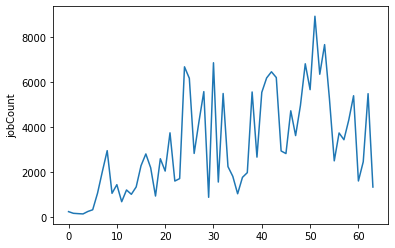

In [44]:
sns.lineplot(x=np.arange(len(active_tasks_users.groupby('date',sort=False).mean())),y=active_tasks_users.groupby('date',sort=False).mean()['jobCount'])


In [11]:
# per project breakdown
# extract job counts and walltime for project grouping
tasks_project = extract_grouping_data(tasks,'groupId','byGroup')

# figures
# set colormap again with length of number of users
# viridis = cm.get_cmap('viridis',len(tasks_project.groupId.unique()))

# # create plot for number of jobs per project over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_project['groupId'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_project.loc[tasks_project['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i])
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Number of Jobs Launched',size=15)
# plt.savefig('./img/number_of_jobs_by_project_since_start_brainlife.png')
# plt.savefig('./img/number_of_jobs_by_project_since_start_brainlife.eps')

# # create plot for walltime per resource over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_project['groupId'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_project.loc[tasks_project['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i])
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Walltime',size=15)
# plt.savefig('./img/total_walltime_by_project_since_start_brainlife.png')
# plt.savefig('./img/total_walltime_by_project_since_start_brainlife.eps')

In [14]:
tasks_project.to_csv('tasks_project_df.csv'

,groupId,date,jobCount,walltime
0,1,2017-1.2017-2,0,0
1,1,2017-2.2017-3,0,0
2,1,2017-3.2017-4,0,0
3,1,2017-4.2017-5,0,0
4,1,2017-5.2017-6,0,0
...,...,...,...,...
157473,17662,2022-7.2022-8,0,0
157474,17662,2022-8.2022-9,0,0
157475,17662,2022-9.2022-10,0,0
157476,17662,2022-10.2022-11,0,0


In [10]:
# per project breakdown - top 10
# extract job counts and walltime for project grouping
project_top_10 = tasks_project.groupby('groupId',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:10]['groupId'].to_list()
tasks_project_top_10 = tasks_project.loc[tasks_project['groupId'].isin(project_top_10)]

# figures
# set colormap again with length of number of users
viridis = cm.get_cmap('viridis',len(tasks_project_top_10.groupId.unique()))

# # create plot for number of jobs per project over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_project_top_10['groupId'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_project_top_10.loc[tasks_project_top_10['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Number of Jobs Launched',size=15)
plt.savefig('./img/number_of_jobs_by_project_top_10_since_start_brainlife.png')
plt.savefig('./img/number_of_jobs_by_project_top_10_since_start_brainlife.eps')

# create plot for walltime per resource over time
fig = plt.figure(figsize=(20,20))
i=0
for r in tasks_project_top_10['groupId'].unique():
    sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_project_top_10.loc[tasks_project_top_10['groupId'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of brainlife',size=15)
plt.ylabel('Total Walltime',size=15)
plt.savefig('./img/total_walltime_by_project_top_10_since_start_brainlife.png')
plt.savefig('./img/total_walltime_by_project_top_10_since_start_brainlife.eps')

NameError: name 'tasks_project' is not defined

In [7]:
# per app breakdown
# extract job counts and walltime for app grouping
tasks_app = extract_grouping_data(tasks,'service','byServices')

## figures
# set colormap again with length of number of apps
viridis = cm.get_cmap('viridis',len(tasks_app.service.unique()))

# create plot for number of jobs per user over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_app['service'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_app.loc[tasks_app['service'] == r].cumsum()[0:-7])
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Number of Jobs Launched',size=15)
# plt.savefig('./img/number_of_jobs_by_app_since_start_brainlife.png')
# plt.savefig('./img/number_of_jobs_by_app_since_start_brainlife.eps')

# # create plot for walltime per resource over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_app['service'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_app.loc[tasks_app['service'] == r].cumsum()[0:-7],color=viridis.colors[i])
#     i=i+1
# plt.legend('',frameon=False)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Walltime',size=15)
# plt.savefig('./img/total_walltime_by_app_since_start_brainlife.png')
# plt.savefig('./img/total_walltime_by_app_since_start_brainlife.eps')

In [8]:
# per app breakdown - top 10
# extract job counts and walltime for app grouping
app_top_10 = tasks_app.groupby('service',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:60]['service'].to_list()
tasks_app_top_10 = tasks_app.loc[tasks_app['service'].isin(app_top_10)]


# ## figures
# # set colormap again with length of number of apps
# viridis = cm.get_cmap('viridis',len(tasks_app_top_10.service.unique()))

# # create plot for number of jobs per user over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_app_top_10['service'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='jobCount',data=tasks_app_top_10.loc[tasks_app_top_10['service'] == r].cumsum()[0:-7],label=r)
#     i=i+1
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Number of Jobs Launched',size=15)
# plt.savefig('./img/number_of_jobs_by_app_top_10_since_start_brainlife.png')
# plt.savefig('./img/number_of_jobs_by_app_top_10_since_start_brainlife.eps')

# # create plot for walltime per resource over time
# fig = plt.figure(figsize=(20,20))
# i=0
# for r in tasks_app_top_10['service'].unique():
#     sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y='walltime',data=tasks_app_top_10.loc[tasks_app_top_10['service'] == r].cumsum()[0:-7],color=viridis.colors[i],label=r)
#     i=i+1
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Walltime',size=15)
# plt.savefig('./img/total_walltime_by_app_top_10_since_start_brainlife.png')
# plt.savefig('./img/total_walltime_by_app_top_10_since_start_brainlife.eps')

In [12]:
tmp = tasks_app.groupby('service',as_index=False).sum().sort_values(by='jobCount',ascending=False)[0:80]
tmp = tmp.loc[tmp.service.str.count('abcd|validator|noop|archive|stage|product') == 0]
tmp['owner'] = [ f.split('/')[0] for f in tmp['service'] ]
tmp['repo'] = [ f.split('/')[1] for f in tmp['service'] ]
tmp_cleaned = tmp.groupby('repo').sum().sort_values(by='jobCount',ascending=False).reset_index(drop=False)
tmp_cleaned.to_csv('top_apps_repos.csv',index=False)
tmp.loc[tmp['repo'].isin(tmp_cleaned.repo.unique().tolist())]

,service,jobCount,walltime,owner,repo
205,brainlife/app-freesurfer,239327,1682029347745,brainlife,app-freesurfer
370,faskowit/app-multiAtlasTT,119125,29126299693,faskowit,app-multiAtlasTT
210,brainlife/app-freesurfer-stats,106224,36411808514,brainlife,app-freesurfer-stats
217,brainlife/app-hcp-acpc-alignment,88744,33402267643,brainlife,app-hcp-acpc-alignment
204,brainlife/app-fmriprep,55769,232062827639,brainlife,app-fmriprep
...,...,...,...,...,...
161,brainlife/app-compile-macro-micro-tract-stats,8445,1448051828,brainlife,app-compile-macro-micro-tract-stats
461,kitchell/app-plot3Dobjects,8188,0,kitchell,app-plot3Dobjects
125,brain-life/app-wmaSeg,7939,0,brain-life,app-wmaSeg
369,faskowit/app-fmri-2-mat,7849,4066580334,faskowit,app-fmri-2-mat


In [80]:
tmp.groupby('repo').sum().sort_values(by=['jobCount','walltime'],ascending=False).reset_index().head(50)

,repo,jobCount,walltime
0,app-freesurfer,239327,1682029347745
1,app-multiAtlasTT,119125,29126299693
2,app-freesurfer-stats,106224,36411808514
3,app-hcp-acpc-alignment,98133,36336271243
4,app-mrtrix3-preproc,70911,201978133276
5,app-mrtrix3-act,59591,219478080542
6,app-fmriprep,55769,232062827639
7,app-tractanalysisprofiles,50779,42432731644
8,app-wmaSeg,41072,134002436285
9,app-tractographyQualityCheck,36799,116805492313


In [30]:
tasks_app_top_10.service.unique()

array(['anibalsolon/HD-BET_app', 'bacaron/app-mrtrix3-act',
       'bcmcpher/app-networkmatrices', 'brain-life/app-dtiinit',
       'brain-life/app-ensembletracking', 'brain-life/app-life',
       'brain-life/app-mrtrix3-act', 'brain-life/app-mrtrix3-preproc',
       'brain-life/app-noddi-amico', 'brain-life/app-roi2roitracking',
       'brain-life/app-roiGenerator',
       'brain-life/app-tractanalysisprofiles', 'brainlife/app-FSLBET',
       'brainlife/app-acpcART', 'brainlife/app-archive',
       'brainlife/app-archive-secondary',
       'brainlife/app-cortex-tissue-mapping',
       'brainlife/app-cortex-tissue-mapping-stats',
       'brainlife/app-endpointMapGeneration', 'brainlife/app-fmriprep',
       'brainlife/app-freesurfer', 'brainlife/app-freesurfer-stats',
       'brainlife/app-fsl-anat', 'brainlife/app-hcp-acpc-alignment',
       'brainlife/app-life', 'brainlife/app-mriqc',
       'brainlife/app-mrtrix3-5tt', 'brainlife/app-mrtrix3-preproc',
       'brainlife/app-networkne

In [13]:
## waffle chart for brainlife software libraries
# load data
apps_software = pd.read_csv('./brainlife-apps-containers-branches-counts-top-50-final.csv')
apps_software

,app,owner,branch,containers,package,version,found_by,jobCount,walltime
0,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,Cython,0.29.32,python-package-cataloger,239327,1682029347745
1,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,ImageMagick,6.9.10.68-6.el7_9,rpm-db-cataloger,239327,1682029347745
2,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,Keras-Preprocessing,1.1.2,python-package-cataloger,239327,1682029347745
3,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,MWMapReduceDriver,NaN,java-cataloger,239327,1682029347745
4,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,MWMapReduceDriver,NaN,java-cataloger,239327,1682029347745
...,...,...,...,...,...,...,...,...,...
494562,app-subj2reference,brainlife,master,docker://brainlife/ants:2.2.0.1,xauth,1:1.0.9-1ubuntu2,dpkgdb-cataloger,7808,10192682992
494563,app-subj2reference,brainlife,master,docker://brainlife/ants:2.2.0.1,xdg-user-dirs,0.15-2ubuntu6.16.04.1,dpkgdb-cataloger,7808,10192682992
494564,app-subj2reference,brainlife,master,docker://brainlife/ants:2.2.0.1,xml-core,0.13+nmu2,dpkgdb-cataloger,7808,10192682992
494565,app-subj2reference,brainlife,master,docker://brainlife/ants:2.2.0.1,xz-utils,5.1.1alpha+20120614-2ubuntu2,dpkgdb-cataloger,7808,10192682992


In [14]:
neuro_packages = ['fsl','freesurfer','mrtrix','nibabel','fmriprep','qsiprep','mriqc','dipy','connectome_workbench','mne','nilearn','pyAFQ']
apps_neuro_software = apps_software.loc[apps_software['package'].isin(neuro_packages)]
apps_neuro_software

,app,owner,branch,containers,package,version,found_by,jobCount,walltime
186,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,freesurfer,0.0.1,python-package-cataloger,239327,1682029347745
466,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,nibabel,3.2.2,python-package-cataloger,239327,1682029347745
732,app-freesurfer,brainlife,master,docker://brainlife/freesurfer:7.3.2,freesurfer,7.3.2,manual-inspection,239327,1682029347745
919,app-freesurfer,brainlife,7.3.2,docker://brainlife/freesurfer:7.3.2,freesurfer,0.0.1,python-package-cataloger,239327,1682029347745
1199,app-freesurfer,brainlife,7.3.2,docker://brainlife/freesurfer:7.3.2,nibabel,3.2.2,python-package-cataloger,239327,1682029347745
...,...,...,...,...,...,...,...,...,...
493150,app-qsiprep,brainlife,0.15.3,docker://pennbbl/qsiprep:0.15.3,dipy,1.4.1,python-package-cataloger,8638,33086580014
493798,app-qsiprep,brainlife,0.15.3,docker://pennbbl/qsiprep:0.15.3,nibabel,3.2.1,python-package-cataloger,8638,33086580014
493801,app-qsiprep,brainlife,0.15.3,docker://pennbbl/qsiprep:0.15.3,nilearn,0.9.0,python-package-cataloger,8638,33086580014
493988,app-qsiprep,brainlife,0.15.3,docker://pennbbl/qsiprep:0.15.3,qsiprep,0.15.3,python-package-cataloger,8638,33086580014


In [57]:
apps_software.loc[apps_software['package'].str.contains('AFQ')]

,app,owner,branch,containers,package,version,found_by,jobCount,walltime
326908,app-tractanalysisprofiles,brainlife,dipy-1.0,docker://brainlife/pyafq:dev,pyAFQ,0.6.dev1467337753,python-package-cataloger,50779,42432731644


In [15]:
apps_neuro_software_counts = apps_neuro_software.groupby(['app','package']).mean().reset_index().groupby('package').sum().sort_values(by='jobCount',ascending=False).reset_index()
apps_neuro_software_counts

,package,jobCount,walltime
0,nibabel,868110.0,2.767682e+12
1,freesurfer,685883.0,2.235318e+12
2,fsl,645719.0,9.774864e+11
3,dipy,554894.0,2.415538e+12
4,mrtrix,259045.0,5.315379e+11
5,nilearn,127263.0,3.664951e+11
6,fmriprep,55769.0,2.320628e+11
7,pyAFQ,50779.0,4.243273e+10
8,connectome_workbench,48180.0,5.741853e+10
9,mne,23003.0,6.555654e+08


In [16]:
total_job_counts = apps_neuro_software.groupby('app').mean().reset_index().sum()['jobCount']
total_job_walltime = apps_neuro_software.groupby('app').mean().reset_index().sum()['walltime']

In [42]:
apps_neuro_software_counts['jobCount_percentage'] = apps_neuro_software_counts.apply(lambda x: (x['jobCount'] / total_job_counts)*100,axis=1)
apps_neuro_software_counts['walltime_percentage'] = apps_neuro_software_counts.apply(lambda x: (x['walltime'] / total_job_walltime)*100,axis=1)
apps_neuro_software_counts['jobCount_percentage_normal'] = (apps_neuro_software_counts.jobCount_percentage / apps_neuro_software_counts.jobCount_percentage.sum())*100
apps_neuro_software_counts['walltime_percentage_normal'] = apps_neuro_software_counts.walltime_percentage / apps_neuro_software_counts.walltime_percentage.sum()
apps_neuro_software_counts

,package,jobCount,walltime,jobCount_percentage,walltime_percentage,jobCount_percentage_normal,walltime_percentage_normal
0,nibabel,868110.0,2.767682e+12,68.617865,86.195481,25.930962,0.285449
1,freesurfer,685883.0,2.235318e+12,54.214129,69.615749,20.487733,0.230543
2,fsl,645719.0,9.774864e+11,51.039453,30.442404,19.288010,0.100815
3,dipy,554894.0,2.415538e+12,43.860388,75.228437,16.575014,0.249130
4,mrtrix,259045.0,5.315379e+11,20.475648,16.553983,7.737828,0.054821
5,nilearn,127263.0,3.664951e+11,10.059227,11.413962,3.801421,0.037799
6,fmriprep,55769.0,2.320628e+11,4.408139,7.227262,1.665853,0.023934
7,pyAFQ,50779.0,4.243273e+10,4.013716,1.321506,1.516799,0.004376
8,connectome_workbench,48180.0,5.741853e+10,3.808283,1.788217,1.439165,0.005922
9,mne,23003.0,6.555654e+08,1.818222,0.020417,0.687113,0.000068


In [31]:
apps_neuro_software_counts.jobCount_percentage / apps_neuro_software_counts.jobCount_percentage.sum()
# (apps_neuro_software_counts['jobCount'] - apps_neuro_software_counts['jobCount'].min()) / (apps_neuro_software_counts['jobCount'].max() - apps_neuro_software_counts['jobCount'].min())    
# (apps_neuro_software_counts['jobCount'] - apps_neuro_software_counts['jobCount'].mean()) / apps_neuro_software_counts['jobCount'].std()    

0     0.259310
1     0.204877
2     0.192880
3     0.165750
4     0.077378
5     0.038014
6     0.016659
7     0.015168
8     0.014392
9     0.006871
10    0.006121
11    0.002580
Name: jobCount_percentage, dtype: float64

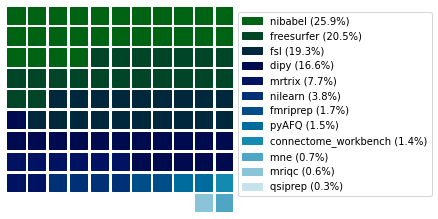

In [76]:

apps_neuro_software_counts_dict = apps_neuro_software_counts.set_index('package').to_dict(orient='dict')

colormaps = list(sns.color_palette("ocean", len(apps_neuro_software_counts_dict['jobCount_percentage_normal'])))

round_apps_neuro_software_counts_dict = apps_neuro_software_counts_dict['jobCount_percentage_normal'].copy()
for key in round_apps_neuro_software_counts_dict:
    round_apps_neuro_software_counts_dict[key] = np.round(round_apps_neuro_software_counts_dict[key],1)

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=round_apps_neuro_software_counts_dict,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in round_apps_neuro_software_counts_dict.items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)


# ax = plt.gca()
# ax.get_legend().remove()
# plt.savefig('apps_neuro_software_waffle.eps',format='eps',bbox_inches='tight')
# plt.savefig('apps_neuro_software_waffle.png',bbox_inches='tight')

In [73]:

f_sum = np.sum([ round_apps_neuro_software_counts_dict[f] for f in round_apps_neuro_software_counts_dict ])

In [74]:
f_sum

101.0

In [99]:
test_sum=0
test_sum = np.sum([ round_apps_neuro_software_counts_dict[f] + test_sum for f in round_apps_neuro_software_counts_dict ])
test_sum

265.0

In [68]:
apps_neuro_software_counts.set_index('package').to_dict(orient='list')




round_dataset_dictionary = dataset_dictionary.copy()
for key in round_dataset_dictionary:
    round_dataset_dictionary[key] = np.round(round_dataset_dictionary[key],1)
# round_dataset_dictionary = [ np.round(round_dataset_dictionary[f],1) for f in round_dataset_dictionary ]

colormaps = list(sns.color_palette("ocean", len(round_dataset_dictionary)))

fig= plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=round_dataset_dictionary,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    colors=colormaps,
    labels=[f"{k} ({v}%)" for k, v in round_dataset_dictionary.items()],
    starting_location='NW',
    vertical=True,
    block_arranging_style='snake',
)
# ax = plt.gca()
# ax.get_legend().remove()
plt.savefig('datasets_waffle.eps',format='eps',bbox_inches='tight')
plt.savefig('datasets_waffle.png',bbox_inches='tight')

{'jobCount': [868110.0,
  685883.0,
  645719.0,
  554894.0,
  259045.0,
  127263.0,
  55769.0,
  50779.0,
  48180.0,
  23003.0,
  20491.0,
  8638.0],
 'walltime': [2767682474278.0,
  2235317761125.0,
  977486365539.0,
  2415537623249.0,
  531537930344.0,
  366495106300.0,
  232062827639.0,
  42432731644.0,
  57418528824.0,
  655565437.0,
  36172890730.0,
  33086580014.0],
 'jobCount_percentage': [68.61786510077565,
  54.21412858844536,
  51.03945264425908,
  43.860388242538164,
  20.47564809186673,
  10.059226787296554,
  4.408139197573069,
  4.013715510652206,
  3.8082832135966305,
  1.8182220581644517,
  1.6196664867125061,
  0.6827719053351534],
 'walltime_percentage': [86.19548103501432,
  69.61574944992314,
  30.442403803847252,
  75.22843726805681,
  16.553982626315904,
  11.413961781417173,
  7.227262247237125,
  1.3215062600843985,
  1.788217311163416,
  0.02041664053492451,
  1.1265525384058848,
  1.0304338400864408]}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


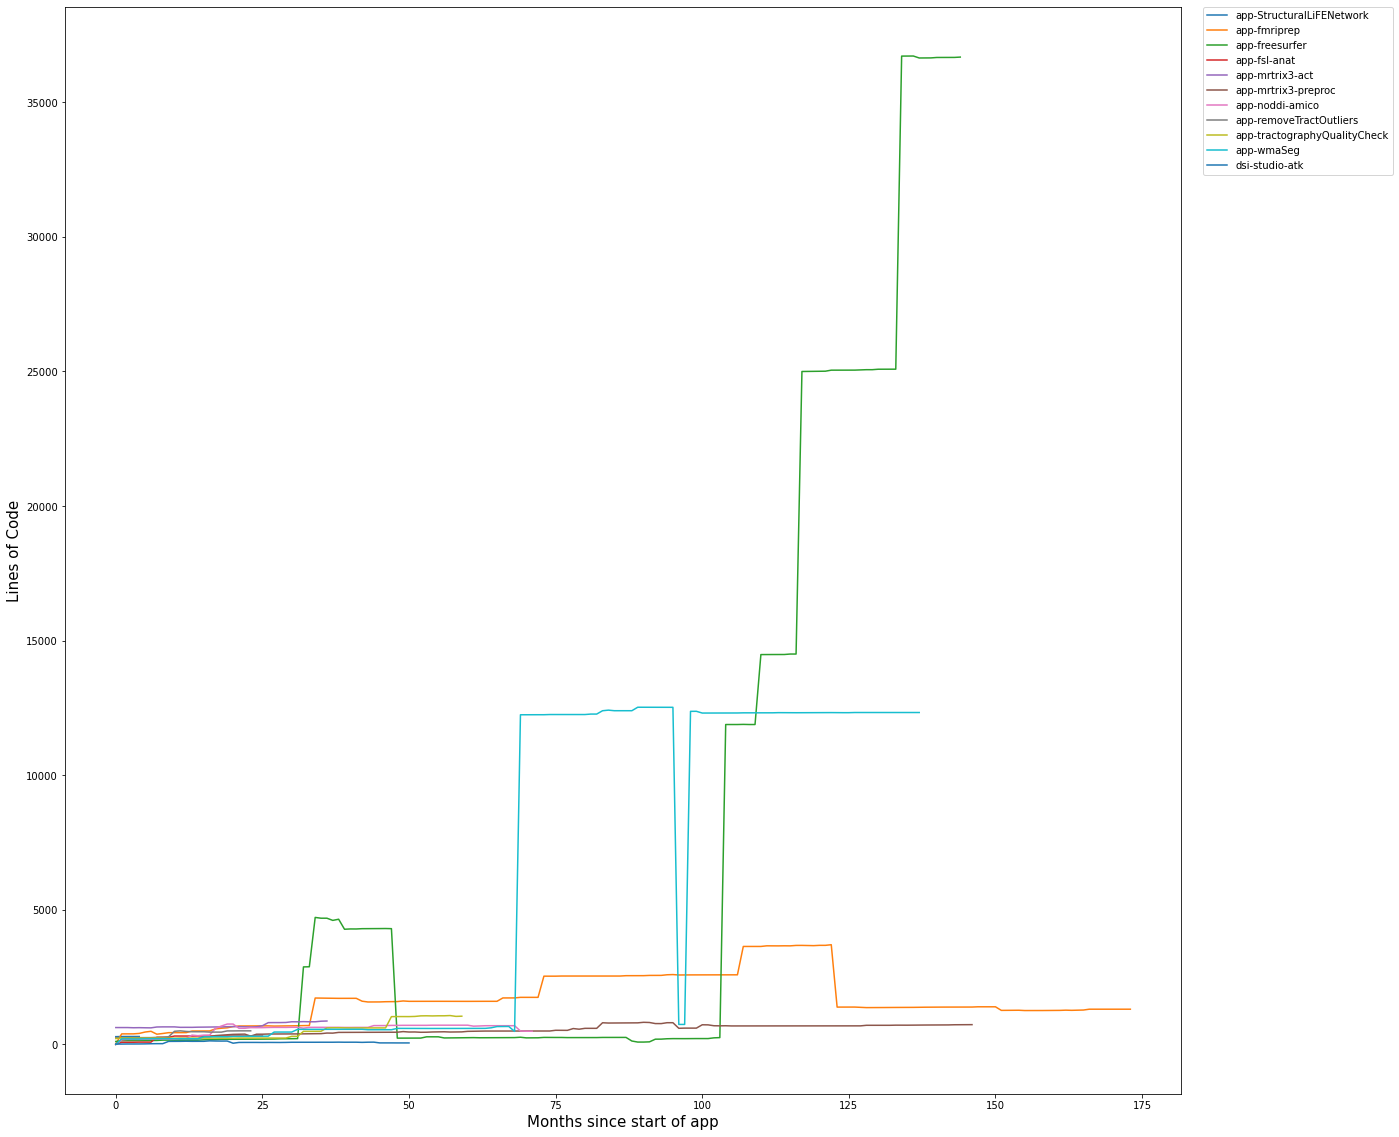

In [7]:
#### github lines analyses
github_lines_data_paths = sorted(glob.glob('./data/github-lines-data/*.csv'))

github_lines_data = pd.DataFrame()

for i in github_lines_data_paths:
    app_name = i.split('./data/github-lines-data/')[1].split('_lines_of_code.csv')[0]
    tmp = pd.read_csv(i)
    tmp['service'] = [ app_name for f in range(len(tmp)) ]
    github_lines_data = pd.concat([github_lines_data,tmp])
    
# reset datetime as actual datetime to use grouper by month
github_lines_data['datetime'] = pd.to_datetime(github_lines_data['datetime'])    

# create plot for total lines of code across top 11 apps over time
# fig = plt.figure(figsize=(20,20))
# sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y=github_lines_data.reset_index(drop=True).groupby(pd.Grouper(key='datetime',freq="M")).sum().cumsum().reset_index()[10:]['lines'])
# plt.xlabel('Months since start of brainlife',size=15)
# plt.ylabel('Total Lines of Code',size=15)
# plt.savefig('./img/total_lines_of_code_top_10_apps_since_start_brainlife.png')
# plt.savefig('./img/total_lines_of_code_top_10_apps_since_start_brainlife.eps')

# create plot of lines of code over time from top 11 apps broken down by app
fig = plt.figure(figsize=(20,20))
i=0
for r in github_lines_data.service.unique():
    sns.lineplot(x=np.arange(0,len(github_lines_data.loc[github_lines_data['service'] == r]['timestamp'])),y='lines',data=github_lines_data.loc[github_lines_data['service'] == r],label=r)
    i=i+1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Months since start of app',size=15)
plt.ylabel('Lines of Code',size=15)
plt.savefig('./img/lines_code_by_app_top_10_since_start_of_app.png')
plt.savefig('./img/lines_code_by_app_top_10_since_start_of_app.eps')

In [124]:
github_lines_data.loc[github_lines_data['service'] == r]

,timestamp,lines,datetime,service
0,1600782645,13,2020-09-22 09:50:45,dsi-studio-atk
1,1600783223,13,2020-09-22 10:00:23,dsi-studio-atk
2,1600784348,16,2020-09-22 10:19:08,dsi-studio-atk
3,1600784884,16,2020-09-22 10:28:04,dsi-studio-atk
4,1600785992,17,2020-09-22 10:46:32,dsi-studio-atk
5,1600789745,20,2020-09-22 11:49:05,dsi-studio-atk
6,1600790905,25,2020-09-22 12:08:25,dsi-studio-atk
7,1600791354,28,2020-09-22 12:15:54,dsi-studio-atk
8,1600792404,28,2020-09-22 12:33:24,dsi-studio-atk
9,1600792441,112,2020-09-22 12:34:01,dsi-studio-atk


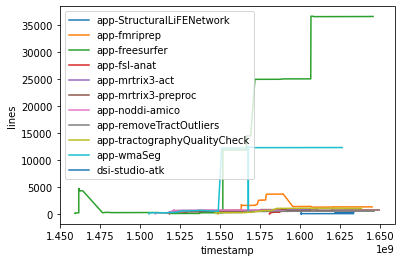

In [38]:
for i in github_lines_data.service.unique():
    sns.lineplot(x='timestamp',y='lines',data=github_lines_data.loc[github_lines_data['service'] == i],label=i)
plt.xticks(
# sns.lineplot(x=np.arange(0,len(github_lines_data)),y='lines',data=github_lines_data.sort_values(by='datetime'))

In [33]:
github_lines_data.sort_values(by='datetime').groupby('service',as_index=False).sum()

,service,timestamp,lines
0,app-StructuralLiFENetwork,8154505789,1463
1,app-fmriprep,275002692389,296502
2,app-freesurfer,219580253007,1088253
3,app-fsl-anat,41176815979,6287
4,app-mrtrix3-act,57528385494,25895
5,app-mrtrix3-preproc,231241031853,79187
6,app-noddi-amico,110559595264,39996
7,app-removeTractOutliers,37792913602,9335
8,app-tractographyQualityCheck,94332305608,29949
9,app-wmaSeg,214143113759,858394


In [40]:
github_lines_data.sort_values(by='datetime')

,timestamp,lines,datetime,service
0,1459365734,110,2016-03-30-15:22:14,app-freesurfer
1,1459369642,138,2016-03-30-16:27:22,app-freesurfer
2,1459369766,140,2016-03-30-16:29:26,app-freesurfer
3,1459370110,140,2016-03-30-16:35:10,app-freesurfer
4,1459370675,142,2016-03-30-16:44:35,app-freesurfer
...,...,...,...,...
23,1646443702,504,2022-03-04-20:28:22,app-removeTractOutliers
143,1649293275,730,2022-04-06-21:01:15,app-mrtrix3-preproc
144,1649429592,730,2022-04-08-10:53:12,app-mrtrix3-preproc
145,1649441899,734,2022-04-08-14:18:19,app-mrtrix3-preproc


In [50]:
github_lines_data['actual_datetime'] = pd.to_datetime(github_lines_data['datetime'])

In [53]:
github_lines_data['actual_datetime'].groupby(pd.Grouper(freq="M"))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [70]:
sns.lineplot(x=np.arange(0,len(list(tasks.keys())[0:-7])),y=github_lines_data.reset_index(drop=True).groupby(pd.Grouper(key='actual_datetime',freq="M")).sum().cumsum()['lines'][0:-7])

ValueError: array length 64 does not match index length 67

In [71]:
github_lines_data.reset_index(drop=True).groupby(pd.Grouper(key='actual_datetime',freq="M")).sum().cumsum()

,timestamp,lines
actual_datetime,,
2016-03-31,26268824142,2726
2016-04-30,56954524441,34609
2016-05-31,70125843265,73269
2016-06-30,70125843265,73269
2016-07-31,70125843265,73269
...,...,...
2021-12-31,1349843602302,2319835
2022-01-31,1353127022471,2393161
2022-02-28,1361353079437,2435062


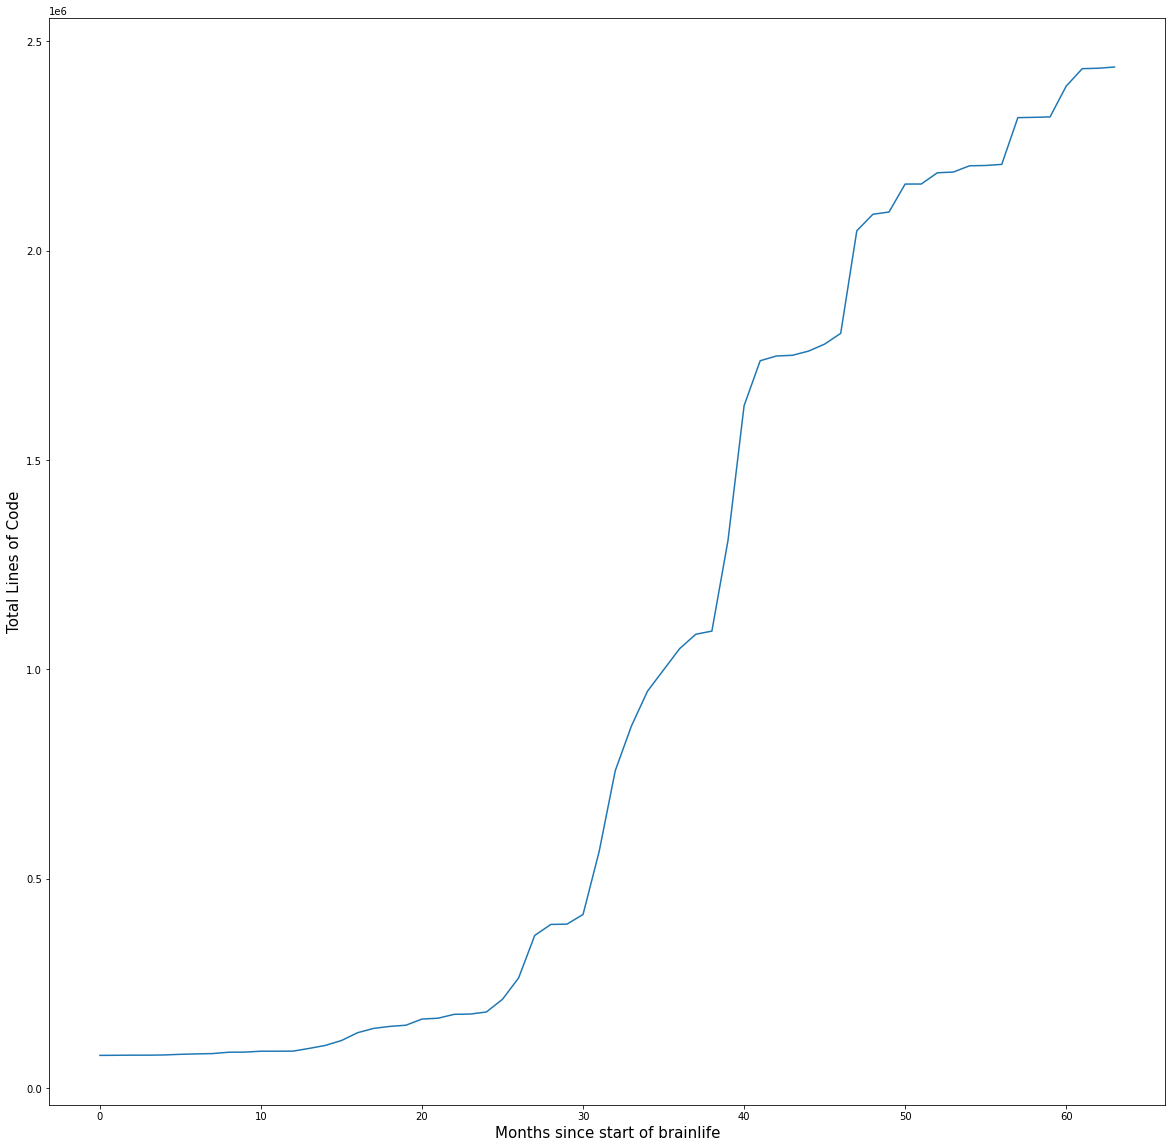

In [ ]:
np.arange(0,len(list(tasks.keys())[0:-7]))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [88]:
github_lines_data.reset_index(drop=True).groupby(pd.Grouper(key='actual_datetime',freq="M")).sum().cumsum().reset_index()[10:]

,actual_datetime,timestamp,lines
10,2017-01-31,98278914459,78008
11,2017-02-28,99766269560,78261
12,2017-03-31,101256147749,78514
13,2017-04-30,101256147749,78514
14,2017-05-31,104247506744,79023
...,...,...,...
69,2021-12-31,1349843602302,2319835
70,2022-01-31,1353127022471,2393161
71,2022-02-28,1361353079437,2435062
72,2022-03-31,1364645966690,2436070


In [97]:
len(app_top_10)


15